# **PRACTICAL 3**: New Dehli air pollution and PM2.5 concentrations

In the following report we will present the New Dehli PM2.5 levels analysis considering Extreme Value methods.

In [22]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
%%R
if (!require(readr)) install.packages("readr")
library(readr)
if (!require(ggplot2)) install.packages("ggplot2")
library(ggplot2)
if (!require(tidyr)) install.packages("tidyr")
library(tidyr)
if (!require(tseries)) install.packages("tseries")
library(tseries)
if (!require(dplyr)) install.packages("dplyr")
library(dplyr)
if (!require(zoo)) install.packages("zoo")
library(zoo)
if (!require(stats)) install.packages("stats")
library(stats)
if (!require(forecast)) install.packages("forecast")
library(forecast)
if (!require(fitdistrplus)) install.packages("fitdistrplus")
library(fitdistrplus)

--- Per piacere, seleziona un mirror CRAN per la sessione ---

I pacchetti binari scaricati sono in
	/var/folders/_z/vq1q1pzj639b28jbhlxzd0zw0000gn/T//RtmpGlgFL3/downloaded_packages


Caricamento del pacchetto richiesto: fitdistrplus
apertura URL 'https://stat.ethz.ch/CRAN/bin/macosx/big-sur-arm64/contrib/4.4/fitdistrplus_1.2-1.tgz'
Content type 'application/x-gzip' length 2094704 bytes (2.0 MB)
downloaded 2.0 MB

Caricamento del pacchetto richiesto: survival
In aggiunta: Messaggio di avvertimento:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  non c'è alcun pacchetto chiamato ‘fitdistrplus’


## 1. Review Dataset

In [24]:
%%R
file_path <- "Data/delhi_aqi.csv"
data <- read_csv(file_path)

Rows: 18776 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): co, no, no2, o3, so2, pm2_5, pm10, nh3
dttm (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [25]:
%%R
head(data)

# A tibble: 6 × 9
  date                   co    no   no2    o3   so2 pm2_5  pm10   nh3
  <dttm>              <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 2020-11-25 01:00:00 2617.  2.18  70.6 13.6   38.6  365.  412.  28.6
2 2020-11-25 02:00:00 3632. 23.2   89.1  0.33  54.4  421.  486.  41.0
3 2020-11-25 03:00:00 4539. 52.8  100.   1.11  68.7  464.  542.  49.1
4 2020-11-25 04:00:00 4539. 51.0  111.   6.44  78.2  455.  534   48.1
5 2020-11-25 05:00:00 4379. 42.9  118.  17.2   87.7  448.  529.  46.6
6 2020-11-25 06:00:00 3899. 28.4  118.  40.0  101.   437.  512.  42.0


In [26]:
%%R
summary(data)

      date                              co                no        
 Min.   :2020-11-25 01:00:00.00   Min.   :  260.4   Min.   :  0.00  
 1st Qu.:2021-06-09 14:45:00.00   1st Qu.: 1068.1   1st Qu.:  0.68  
 Median :2021-12-22 04:30:00.00   Median : 1842.5   Median :  5.25  
 Mean   :2021-12-23 14:35:34.38   Mean   : 2929.2   Mean   : 33.66  
 3rd Qu.:2022-07-07 18:15:00.00   3rd Qu.: 3685.0   3rd Qu.: 35.76  
 Max.   :2023-01-24 08:00:00.00   Max.   :21148.7   Max.   :500.68  
      no2               o3              so2             pm2_5        
 Min.   :  4.28   Min.   :  0.00   Min.   :  5.25   Min.   :  11.83  
 1st Qu.: 33.93   1st Qu.:  0.34   1st Qu.: 34.81   1st Qu.:  84.44  
 Median : 54.15   Median : 27.18   Median : 52.93   Median : 157.44  
 Mean   : 66.22   Mean   : 60.35   Mean   : 66.69   Mean   : 238.13  
 3rd Qu.: 83.63   3rd Qu.: 92.98   3rd Qu.: 82.02   3rd Qu.: 313.00  
 Max.   :460.62   Max.   :801.09   Max.   :579.83   Max.   :1708.09  
      pm10              nh3

In [27]:
%%R
sample_data <- data[sample(nrow(data), 100), ]
print(sample_data)

# A tibble: 100 × 9
   date                   co     no   no2     o3   so2 pm2_5  pm10   nh3
   <dttm>              <dbl>  <dbl> <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl>
 1 2020-12-23 04:00:00 9293. 216.    80.9   2.17  64.8 813.  935.  23.0 
 2 2021-03-21 22:00:00 1442.   0.01  39.4  34.0   41.0 121.  168.  25.3 
 3 2021-03-30 05:00:00  754.   5.53  25.4  95.8   31.0  73.1 170.  19.2 
 4 2022-08-23 19:00:00  454.   0     18.0  55.8   21.2  24.4  30.2  8.49
 5 2021-02-23 11:00:00 3899.  30.8  145.   57.2   92.5 268.  338   38   
 6 2022-09-19 10:00:00 1015.   0.92  22.6 269.    71.5 205.  267.  10.8 
 7 2021-12-14 01:00:00 4753.  45.2   66.5   0     40.0 559.  632.  16.5 
 8 2022-04-25 16:00:00 1375.   0     43.2  83.0   53.4  81.8 142.  29.1 
 9 2022-12-16 17:00:00 9079. 229.    70.6   0     85.8 634.  821.  67.9 
10 2021-11-30 05:00:00 2430.  11.4   57.6  68.7   65.8 308.  351.  20.8 
# ℹ 90 more rows
# ℹ Use `print(n = ...)` to see more rows


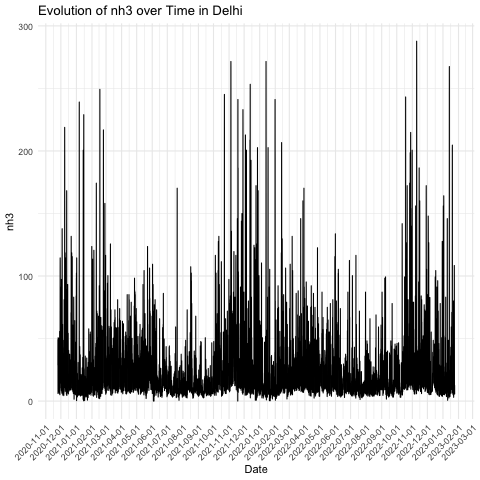

In [28]:
%%R
if (!dir.exists("Images")) {
  dir.create("Images")}

data$date <- as.POSIXct(data$date, format = "%Y-%m-%d %H:%M:%S")
pollutants <- c("co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3")

for (pollutant in pollutants) {
  plot <- ggplot(data, aes(x = date, y = .data[[pollutant]])) +
    geom_line() +
    labs(
      title = paste("Evolution of", pollutant, "over Time in Delhi"),
      x = "Date",
      y = pollutant
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_datetime(date_labels = "%Y-%m-%d", date_breaks = "1 month")
  
  ggsave(filename = paste0("Images/delhi_", pollutant, "_over_time.png"), plot = plot, width = 10, height = 6)
  
  print(plot)
}

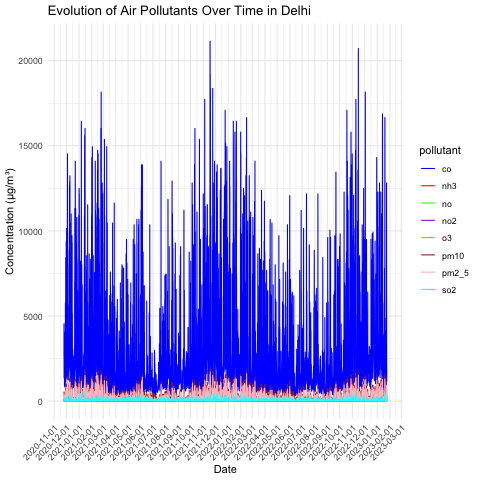

In [29]:
%%R
data$date <- as.POSIXct(data$date, format = "%Y-%m-%d %H:%M:%S")

data_long <- data %>%
  pivot_longer(cols = -date, names_to = "pollutant", values_to = "value")

ggplot(data_long, aes(x = date, y = value, color = pollutant)) +
  geom_line() +
  labs(title = "Evolution of Air Pollutants Over Time in Delhi",
       x = "Date",
       y = "Concentration (µg/m³)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_x_datetime(date_labels = "%Y-%m-%d", date_breaks = "1 month") +
  scale_color_manual(values = c("blue", "red", "green", "purple", "orange", "brown", "pink", "cyan"))

We are going to focus on PM2.5.

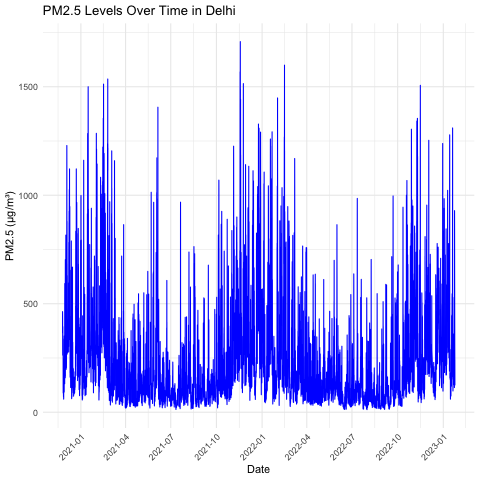

In [30]:
%%R
ggplot(data, aes(x = date, y = pm2_5)) +
  geom_line(color = "blue") +
  labs(title = "PM2.5 Levels Over Time in Delhi",
       x = "Date",
       y = "PM2.5 (µg/m³)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_x_datetime(date_labels = "%Y-%m", date_breaks = "3 months")

## 2. Stationarity Analysis

In [34]:
%%R
pm2_5 <- data$pm2_5

adf_test_result <- adf.test(pm2_5, alternative = "stationary")


cat("Augmented Dickey-Fuller Test Results:\n")
cat("-----------------------------------\n")
cat("Test Statistic: ", adf_test_result$statistic, "\n")
cat("P-Value: ", adf_test_result$p.value, "\n")
cat("Number of Lags Used: ", adf_test_result$parameter, "\n")
cat("Critical Values:\n")
for (name in names(adf_test_result$critical.values)) {
  cat("  ", name, ":", adf_test_result$critical.values[[name]], "\n")
}
cat("-----------------------------------\n")

if (adf_test_result$p.value < 0.05) {
  cat("The series is stationary (reject the null hypothesis).\n")
} else {
  cat("The series is not stationary (fail to reject the null hypothesis).\n")
}

Augmented Dickey-Fuller Test Results:
-----------------------------------
Test Statistic:  -12.70354 
P-Value:  0.01 
Number of Lags Used:  26 
Critical Values:
-----------------------------------
The series is stationary (reject the null hypothesis).


In aggiunta: Messaggio di avvertimento:
In adf.test(pm2_5, alternative = "stationary") :
  p-value smaller than printed p-value


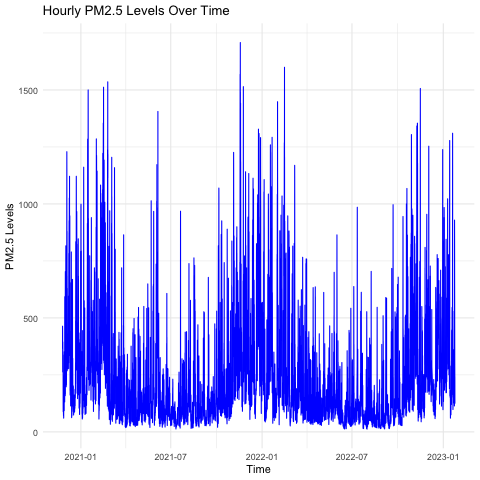

In [35]:
%%R
ggplot(data = data, aes(x = date, y = pm2_5)) +
  geom_line(color = "blue") +
  labs(title = "Hourly PM2.5 Levels Over Time",
       x = "Time",
       y = "PM2.5 Levels") +
  theme_minimal()

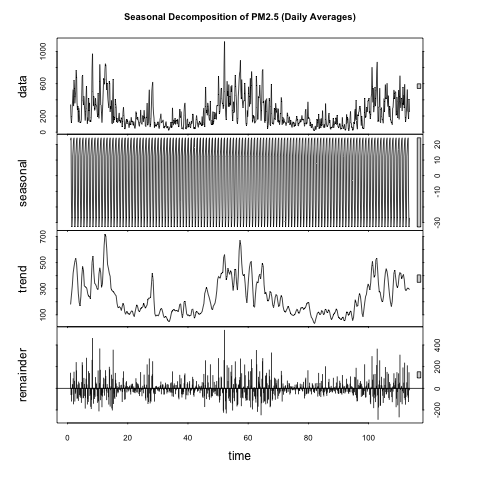

In [36]:
%%R
pm2_5_daily <- data %>%
  mutate(date = as.Date(date)) %>% 
  group_by(date) %>%
  summarise(pm2_5 = mean(pm2_5, na.rm = TRUE))

pm2_5_daily$pm2_5 <- na.approx(pm2_5_daily$pm2_5)

decomposition <- stl(ts(pm2_5_daily$pm2_5, frequency = 7), s.window = "periodic")

plot(decomposition, main = "Seasonal Decomposition of PM2.5 (Daily Averages)")

Overall Interpretation

- Strong Seasonality: The seasonal component shows clear weekly patterns, suggesting consistent pollution behaviors tied to human activities or weather conditions.
- Long-term Trends: The trend component highlights periods of increasing or decreasing pollution, which can inform policy measures.
- Unexplained Variability: The residual component shows random variations, which could be attributed to exceptional events.

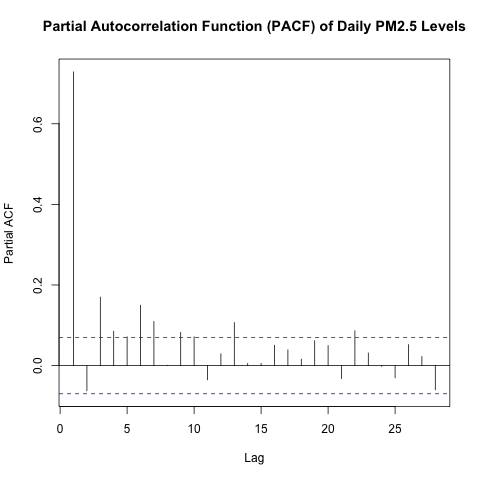

In [37]:
%%R
acf(pm2_5_daily$pm2_5, main = "Autocorrelation Function (ACF) of Daily PM2.5 Levels")
pacf(pm2_5_daily$pm2_5, main = "Partial Autocorrelation Function (PACF) of Daily PM2.5 Levels")

ACF:

- Significant correlations up to lag 10 suggest that PM2.5 levels are influenced by recent past values.
- The gradual decay indicates potential non-stationarity or a trend in the data.

PACF:

- Significant spikes at lag 1 and lag 2 suggest that PM2.5 levels are best explained by an autoregressive model of order 2 (AR(2)).
- After lag 2, correlations are insignificant, indicating no additional lags are needed.

Summary:

- The time series likely has a trend or non-stationarity.The PM2.5 data is statistically stationary (as per the ADF test), but the ACF and PACF reveal seasonal patterns and short-term dependencies. The apparent "non-stationarity" in the ACF is due to strong seasonality and potential short-term trends.
- PM2.5 levels today are influenced by values from the past 1-2 days.
- An AR(2) or ARIMA model could be suitable for forecasting.


![Description of the image](RiskAnalytics/Images/download.png)

Figure 1: Nine examples of time series data; (a) Google stock price for 200 consecutive days; (b) Daily change in the Google stock price for 200 consecutive days; (c) Annual number of strikes in the US; (d) Monthly sales of new one-family houses sold in the US; (e) Annual price of a dozen eggs in the US (constant dollars); (f) Monthly total of pigs slaughtered in Victoria, Australia; (g) Annual total of lynx trapped in the McKenzie River district of north-west Canada; (h) Monthly Australian beer production; (i) Monthly Australian electricity production. [Hyndman & Athanasopoulos, 2018]

Seasonality can be observed in series (d), (h), and (i) The trend can be observed in series (a), (c), (e), (f), and (i) Series (b) and (g) are stationary Statistical Tests

Here I've checked the sationarity using differents lags, and it seems the data are not stationary, but it's probably because of the seasonalities and the fact taht we have only 2 years of observations.

I've tried to fix not stationary with logs, but it didn't change anything.

In [38]:
%%R
if (FALSE) {
  if (!require(vars)) install.packages("vars")
  library(vars)

  pm2_5_values_all <- data$pm2_5

  lag_selection_all <- VARselect(pm2_5_values_all, lag.max = 458, type = "const")

  cat("Optimal lag length suggested by AIC, BIC, HQ:\n")
  print(lag_selection_all$selection)
}

In [39]:
%%R
pm2_5_values_all <- data$pm2_5

adf_result <- adf.test(pm2_5_values_all, alternative = "stationary", k = 312)

cat("Dickey-Fuller Test Results with Lag 218:\n")
print(adf_result)

Dickey-Fuller Test Results with Lag 218:

	Augmented Dickey-Fuller Test

data:  pm2_5_values_all
Dickey-Fuller = -3.6892, Lag order = 312, p-value = 0.02435
alternative hypothesis: stationary



Here we use the method "legacy_lag <- as.integer(12 * (n / 100)^(1 / 4))" to calculate the good number of lags to use. Results = Stationary for hourly data

In [40]:
%%R
if (!require(tseries)) install.packages("tseries")
library(tseries)

pm2_5_values_all <- data$pm2_5

n <- length(pm2_5_values_all)

legacy_lag <- as.integer(12 * (n / 100)^(1 / 4))
cat("Number of lags using the legacy method:", legacy_lag, "\n")

adf_result <- adf.test(pm2_5_values_all, alternative = "stationary", k = legacy_lag)

cat("Dickey-Fuller Test Results with Lag", legacy_lag, ":\n")
print(adf_result)

Number of lags using the legacy method: 44 
Dickey-Fuller Test Results with Lag 44 :

	Augmented Dickey-Fuller Test

data:  pm2_5_values_all
Dickey-Fuller = -9.8035, Lag order = 44, p-value = 0.01
alternative hypothesis: stationary



In aggiunta: Messaggio di avvertimento:
In adf.test(pm2_5_values_all, alternative = "stationary", k = legacy_lag) :
  p-value smaller than printed p-value


In [41]:
%%R
if (!require(vars)) install.packages("vars")
library(vars)
pm2_5_values_all <- as.matrix(data$pm2_5)

pm2_5_sample <- pm2_5_values_all[1:1000, ]
lag_selection <- VARselect(pm2_5_sample, lag.max = 100, type = "const")

cat("Lag Selection Results:\n")
print(lag_selection$selection)

optimal_aic <- lag_selection$selection["AIC(n)"]
optimal_bic <- lag_selection$selection["SC(n)"]
optimal_hq <- lag_selection$selection["HQ(n)"]

cat("Optimal Lags:\n")
cat("AIC:", optimal_aic, "\n")
cat("BIC:", optimal_bic, "\n")
cat("HQ:", optimal_hq, "\n")

Lag Selection Results:
AIC(n)  HQ(n)  SC(n) FPE(n) 
    50     26     26     50 
Optimal Lags:
AIC: 50 
BIC: 26 
HQ: 26 


Caricamento del pacchetto richiesto: vars
Caricamento del pacchetto richiesto: MASS

Caricamento pacchetto: ‘MASS’

Il seguente oggetto è mascherato da ‘package:dplyr’:

    select

Caricamento del pacchetto richiesto: strucchange
Caricamento del pacchetto richiesto: sandwich
Caricamento del pacchetto richiesto: urca
Caricamento del pacchetto richiesto: lmtest


In [42]:
%%R
pm2_5_values_all <- data$pm2_5
adf_result <- adf.test(pm2_5_values_all, alternative = "stationary", k = 218)
cat("Dickey-Fuller Test Results with Lag 218:\n")
print(adf_result)

Dickey-Fuller Test Results with Lag 218:

	Augmented Dickey-Fuller Test

data:  pm2_5_values_all
Dickey-Fuller = -4.3572, Lag order = 218, p-value = 0.01
alternative hypothesis: stationary



In aggiunta: Messaggio di avvertimento:
In adf.test(pm2_5_values_all, alternative = "stationary", k = 218) :
  p-value smaller than printed p-value


In [43]:
%%R
pm2_5_values_all <- data$pm2_5
adf_result <- adf.test(pm2_5_values_all, alternative = "stationary", k = 170)
cat("Dickey-Fuller Test Results with Lag 218:\n")
print(adf_result)

Dickey-Fuller Test Results with Lag 218:

	Augmented Dickey-Fuller Test

data:  pm2_5_values_all
Dickey-Fuller = -4.9888, Lag order = 170, p-value = 0.01
alternative hypothesis: stationary



In aggiunta: Messaggio di avvertimento:
In adf.test(pm2_5_values_all, alternative = "stationary", k = 170) :
  p-value smaller than printed p-value


Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) Test checks whether a time series is stationary, meaning its statistical properties (mean, variance, and autocorrelation) do not change over time. Here's how the ADF test works:

Null Hypothesis (H₀): The time series has a unit root (non-stationary). It exhibits trends or changing variance over time. Alternative Hypothesis (H₁): The time series does not have a unit root (stationary). It has constant statistical properties.

Here I tested different type of data, average daily data (1 observation = 1 day), weekly, and monthly data. For each, I founded the best lag using AIC. Then the optimal lag is used for each stationary test (Augmented Dickey-Fuller Test)

Why Does Time Scale Matter?

Granular (Hourly) Data:

With hourly data, the series often exhibits short-term fluctuations but may not capture larger trends or seasonality. The Augmented Dickey-Fuller (ADF) test in this case focuses on those short-term dynamics, potentially identifying the series as stationary. Daily Aggregates:

When you average the data by day, daily patterns and trends become more apparent. For example, PM2.5 levels may exhibit seasonality (e.g., higher in winter months), but the ADF test may still identify the series as stationary if the trends are subtle. Weekly or Monthly Aggregates:

At these larger scales, long-term trends or seasonal cycles become more dominant. For example: A yearly increase in pollution due to urbanization. Seasonal peaks due to winter weather or specific events. These factors make the series appear non-stationary because the long-term mean and variance are no longer constant. Key Insights: Hourly data: Captures short-term dynamics → Often stationary (short-term variability dominates). Daily or weekly data: Captures broader trends → May be non-stationary due to long-term trends or seasonality. Choosing the Right Time Scale: Depends on the type of analysis you need: For short-term forecasts, using the original (hourly) data may be better. For long-term trends or aggregate behavior, working with weekly or monthly data makes more sense, even if it’s non-stationary (you can remove trends as needed).

How to Address This?

If you need stationarity across all scales: Detrending: Subtract the long-term trend (e.g., using a linear or moving average trend). Differencing: Take first or seasonal differences (e.g., subtract the value from the same week in the previous year). Seasonal Decomposition: Remove seasonal components explicitly. Would you like to perform one of these adjustments?

In [45]:
%%R
if (!require(lubridate)) install.packages("lubridate")
library(lubridate)


# Aggregate to daily averages and find optimal lag
cat("\nCalculating Daily Averages and Finding Optimal Lag:\n")
daily_data <- aggregate(pm2_5_values_all, by = list(as.Date(data$date)), FUN = mean)
colnames(daily_data) <- c("Date", "Daily_Avg_PM2_5")
daily_lag_selection <- VARselect(daily_data$Daily_Avg_PM2_5, lag.max = 30, type = "const")
optimal_daily_lag <- daily_lag_selection$selection["AIC(n)"]
cat("Optimal Lag for Daily Averages (AIC):", optimal_daily_lag, "\n")
adf_daily <- adf.test(daily_data$Daily_Avg_PM2_5, alternative = "stationary", k = optimal_daily_lag)
cat("ADF Test Results for Daily Averages:\n")
print(adf_daily)

# Aggregate to weekly averages and find optimal lag
cat("\nCalculating Weekly Averages and Finding Optimal Lag:\n")
data$Week <- floor_date(data$date, "week")
weekly_data <- aggregate(pm2_5_values_all, by = list(data$Week), FUN = mean)
colnames(weekly_data) <- c("Week", "Weekly_Avg_PM2_5")
weekly_lag_selection <- VARselect(weekly_data$Weekly_Avg_PM2_5, lag.max = 12, type = "const")
optimal_weekly_lag <- weekly_lag_selection$selection["AIC(n)"]
cat("Optimal Lag for Weekly Averages (AIC):", optimal_weekly_lag, "\n")
adf_weekly <- adf.test(weekly_data$Weekly_Avg_PM2_5, alternative = "stationary", k = optimal_weekly_lag)
cat("ADF Test Results for Weekly Averages:\n")
print(adf_weekly)

# Aggregate to monthly averages and find optimal lag
cat("\nCalculating Monthly Averages and Finding Optimal Lag:\n")
data$Month <- floor_date(data$date, "month")
monthly_data <- aggregate(pm2_5_values_all, by = list(data$Month), FUN = mean)
colnames(monthly_data) <- c("Month", "Monthly_Avg_PM2_5")
monthly_lag_selection <- VARselect(monthly_data$Monthly_Avg_PM2_5, lag.max = 12, type = "const")
optimal_monthly_lag <- monthly_lag_selection$selection["AIC(n)"]
cat("Optimal Lag for Monthly Averages (AIC):", optimal_monthly_lag, "\n")
adf_monthly <- adf.test(monthly_data$Monthly_Avg_PM2_5, alternative = "stationary", k = optimal_monthly_lag)
cat("ADF Test Results for Monthly Averages:\n")
print(adf_monthly)



Calculating Daily Averages and Finding Optimal Lag:
Optimal Lag for Daily Averages (AIC): 13 
ADF Test Results for Daily Averages:

	Augmented Dickey-Fuller Test

data:  daily_data$Daily_Avg_PM2_5
Dickey-Fuller = -3.6507, Lag order = 13, p-value = 0.02782
alternative hypothesis: stationary


Calculating Weekly Averages and Finding Optimal Lag:
Optimal Lag for Weekly Averages (AIC): 3 
ADF Test Results for Weekly Averages:

	Augmented Dickey-Fuller Test

data:  weekly_data$Weekly_Avg_PM2_5
Dickey-Fuller = -2.3458, Lag order = 3, p-value = 0.4331
alternative hypothesis: stationary


Calculating Monthly Averages and Finding Optimal Lag:
Optimal Lag for Monthly Averages (AIC): 7 
ADF Test Results for Monthly Averages:

	Augmented Dickey-Fuller Test

data:  monthly_data$Monthly_Avg_PM2_5
Dickey-Fuller = -3.4569, Lag order = 7, p-value = 0.06941
alternative hypothesis: stationary



In [47]:
%%R
log_pm2_5_values <- log(pm2_5_values_all)

# ADF test on the full dataset (hourly)
cat("\nADF Test on Hourly Log PM2.5 Data:\n")
hourly_lag_selection <- VARselect(log_pm2_5_values, lag.max = 30, type = "const")
optimal_hourly_lag <- hourly_lag_selection$selection["AIC(n)"]
adf_hourly <- adf.test(log_pm2_5_values, alternative = "stationary", k = optimal_hourly_lag)
cat("Optimal Lag for Hourly Log PM2.5 (AIC):", optimal_hourly_lag, "\n")
print(adf_hourly)

# Aggregate to daily averages and find optimal lag
cat("\nCalculating Daily Log Averages and Finding Optimal Lag:\n")
daily_data <- aggregate(log_pm2_5_values, by = list(as.Date(data$date)), FUN = mean)
colnames(daily_data) <- c("Date", "Daily_Log_Avg_PM2_5")
daily_lag_selection <- VARselect(daily_data$Daily_Log_Avg_PM2_5, lag.max = 30, type = "const")
optimal_daily_lag <- daily_lag_selection$selection["AIC(n)"]
adf_daily <- adf.test(daily_data$Daily_Log_Avg_PM2_5, alternative = "stationary", k = optimal_daily_lag)
cat("Optimal Lag for Daily Log PM2.5 (AIC):", optimal_daily_lag, "\n")
print(adf_daily)

# Aggregate to weekly averages and find optimal lag
cat("\nCalculating Weekly Log Averages and Finding Optimal Lag:\n")
data$Week <- floor_date(data$date, "week")
weekly_data <- aggregate(log_pm2_5_values, by = list(data$Week), FUN = mean)
colnames(weekly_data) <- c("Week", "Weekly_Log_Avg_PM2_5")
weekly_lag_selection <- VARselect(weekly_data$Weekly_Log_Avg_PM2_5, lag.max = 12, type = "const")
optimal_weekly_lag <- weekly_lag_selection$selection["AIC(n)"]
adf_weekly <- adf.test(weekly_data$Weekly_Log_Avg_PM2_5, alternative = "stationary", k = optimal_weekly_lag)
cat("Optimal Lag for Weekly Log PM2.5 (AIC):", optimal_weekly_lag, "\n")
print(adf_weekly)

# Aggregate to monthly averages and find optimal lag
cat("\nCalculating Monthly Log Averages and Finding Optimal Lag:\n")
data$Month <- floor_date(data$date, "month")
monthly_data <- aggregate(log_pm2_5_values, by = list(data$Month), FUN = mean)
colnames(monthly_data) <- c("Month", "Monthly_Log_Avg_PM2_5")
monthly_lag_selection <- VARselect(monthly_data$Monthly_Log_Avg_PM2_5, lag.max = 12, type = "const")
optimal_monthly_lag <- monthly_lag_selection$selection["AIC(n)"]
adf_monthly <- adf.test(monthly_data$Monthly_Log_Avg_PM2_5, alternative = "stationary", k = optimal_monthly_lag)
cat("Optimal Lag for Monthly Log PM2.5 (AIC):", optimal_monthly_lag, "\n")
print(adf_monthly)


ADF Test on Hourly Log PM2.5 Data:


Optimal Lag for Hourly Log PM2.5 (AIC): 29 

	Augmented Dickey-Fuller Test

data:  log_pm2_5_values
Dickey-Fuller = -11.333, Lag order = 29, p-value = 0.01
alternative hypothesis: stationary


Calculating Daily Log Averages and Finding Optimal Lag:
Optimal Lag for Daily Log PM2.5 (AIC): 10 

	Augmented Dickey-Fuller Test

data:  daily_data$Daily_Log_Avg_PM2_5
Dickey-Fuller = -3.527, Lag order = 10, p-value = 0.03971
alternative hypothesis: stationary


Calculating Weekly Log Averages and Finding Optimal Lag:
Optimal Lag for Weekly Log PM2.5 (AIC): 3 

	Augmented Dickey-Fuller Test

data:  weekly_data$Weekly_Log_Avg_PM2_5
Dickey-Fuller = -2.0243, Lag order = 3, p-value = 0.5665
alternative hypothesis: stationary


Calculating Monthly Log Averages and Finding Optimal Lag:
Optimal Lag for Monthly Log PM2.5 (AIC): 8 

	Augmented Dickey-Fuller Test

data:  monthly_data$Monthly_Log_Avg_PM2_5
Dickey-Fuller = -2.8016, Lag order = 8, p-value = 0.2665
alternative hypothesis: stationary



In aggiunta: Messaggio di avvertimento:
In adf.test(log_pm2_5_values, alternative = "stationary", k = optimal_hourly_lag) :
  p-value smaller than printed p-value


## 3. Exploratory Analysis

Here we plot all the data, to visually check and find the seasonalities (which probably makes the data non-stationary).

We can definitely see peaks every winter.

### 3.1. Without Log (Raw Data)

Let's print all the data:

- Hourly data
- Day avergae data
- Week average
- Months avergage

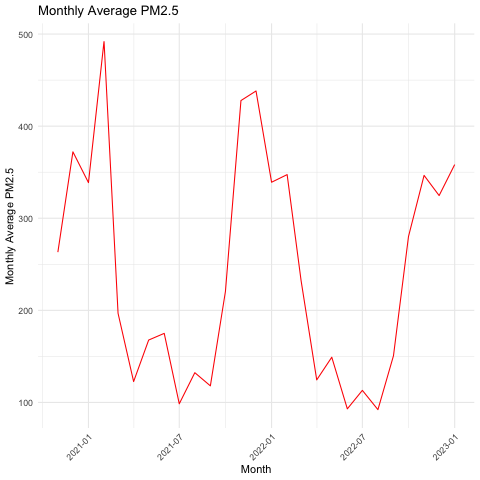

In [48]:
%%R
hourly_plot <- ggplot(data, aes(x = date, y = pm2_5)) +
  geom_line(color = "blue") +
  labs(title = "Hourly PM2.5 Observations", x = "Date", y = "PM2.5") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Daily averages
daily_data <- aggregate(pm2_5_values_all, by = list(as.Date(data$date)), FUN = mean)
colnames(daily_data) <- c("Date", "Daily_Avg_PM2_5")
daily_plot <- ggplot(daily_data, aes(x = Date, y = Daily_Avg_PM2_5)) +
  geom_line(color = "green") +
  labs(title = "Daily Average PM2.5", x = "Date", y = "Daily Average PM2.5") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Weekly averages
data$Week <- floor_date(data$date, "week")
weekly_data <- aggregate(pm2_5_values_all, by = list(data$Week), FUN = mean)
colnames(weekly_data) <- c("Week", "Weekly_Avg_PM2_5")
weekly_plot <- ggplot(weekly_data, aes(x = Week, y = Weekly_Avg_PM2_5)) +
  geom_line(color = "orange") +
  labs(title = "Weekly Average PM2.5", x = "Week", y = "Weekly Average PM2.5") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Monthly averages
data$Month <- floor_date(data$date, "month")
monthly_data <- aggregate(pm2_5_values_all, by = list(data$Month), FUN = mean)
colnames(monthly_data) <- c("Month", "Monthly_Avg_PM2_5")
monthly_plot <- ggplot(monthly_data, aes(x = Month, y = Monthly_Avg_PM2_5)) +
  geom_line(color = "red") +
  labs(title = "Monthly Average PM2.5", x = "Month", y = "Monthly Average PM2.5") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Display all plots
print(hourly_plot)
print(daily_plot)
print(weekly_plot)
print(monthly_plot)

Here, let's print a specific period:

- for hourly, one entire day only
- for hourly again, one entire week
- for daily, 1 entire month
- for weekly, 1 entire year
- for monthly, 1 entire year too

In aggiunta: Messaggio di avvertimento:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


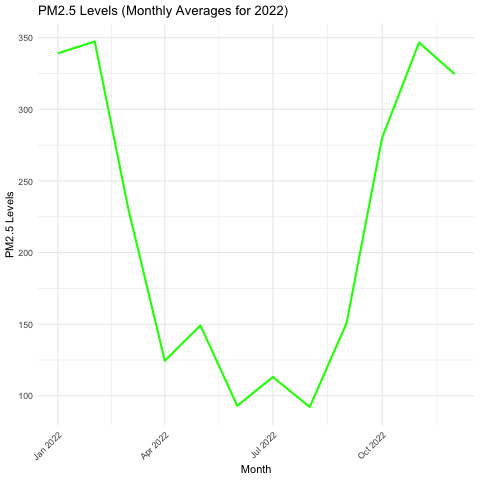

In [49]:
%%R
one_day_data <- data[as.Date(data$date) == as.Date("2021-01-05"), ]

# Plot hourly observations for the selected day
ggplot(one_day_data, aes(x = date, y = pm2_5)) +
  geom_line(color = "blue", size = 1) +
  labs(title = "PM2.5 Levels (Hourly Observations for January 5, 2021)",
       x = "Time", y = "PM2.5 Levels") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Filter data for one week in 2021 (e.g., Monday to Sunday, January 4th to January 10th, 2021)
one_week_data <- data[as.Date(data$date) >= as.Date("2021-01-04") &
                                  as.Date(data$date) <= as.Date("2021-01-10"), ]

# Plot hourly observations for the selected week
ggplot(one_week_data, aes(x = date, y = pm2_5)) +
  geom_line(color = "blue", size = 1) +
  labs(title = "PM2.5 Levels (Hourly Observations for One Week in 2021)",
       x = "Date", y = "PM2.5 Levels") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Filter data for one month in 2022 (e.g., January)
data$Date <- as.Date(data$date)
one_month_data <- data[year(data$Date) == 2022 & month(data$Date) == 1, ]
daily_avg_one_month <- aggregate(one_month_data$pm2_5, by = list(one_month_data$Date), FUN = mean)
colnames(daily_avg_one_month) <- c("Date", "Daily_Avg_PM2_5")

# Plot daily averages for the selected month
ggplot(daily_avg_one_month, aes(x = Date, y = Daily_Avg_PM2_5)) +
  geom_line(color = "red", size = 1) +
  labs(title = "PM2.5 Levels (Daily Averages for January 2022)",
       x = "Date", y = "PM2.5 Levels") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Filter data for one year in 2022
one_year_data <- data[year(as.Date(data$date)) == 2022, ]
one_year_data$Week <- floor_date(one_year_data$date, "week")

# Calculate weekly averages for the year
weekly_avg_one_year <- aggregate(one_year_data$pm2_5, by = list(one_year_data$Week), FUN = mean)
colnames(weekly_avg_one_year) <- c("Week", "Weekly_Avg_PM2_5")

# Plot weekly averages for the selected year
ggplot(weekly_avg_one_year, aes(x = Week, y = Weekly_Avg_PM2_5)) +
  geom_line(color = "purple", size = 1) +
  labs(title = "PM2.5 Levels (Weekly Averages for 2022)",
       x = "Week", y = "PM2.5 Levels") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Calculate monthly averages for the year
one_year_data$Month <- floor_date(one_year_data$date, "month")
monthly_avg_one_year <- aggregate(one_year_data$pm2_5, by = list(one_year_data$Month), FUN = mean)
colnames(monthly_avg_one_year) <- c("Month", "Monthly_Avg_PM2_5")

# Plot monthly averages for the selected year
ggplot(monthly_avg_one_year, aes(x = Month, y = Monthly_Avg_PM2_5)) +
  geom_line(color = "green", size = 1) +
  labs(title = "PM2.5 Levels (Monthly Averages for 2022)",
       x = "Month", y = "PM2.5 Levels") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

`geom_smooth()` using formula = 'y ~ x'


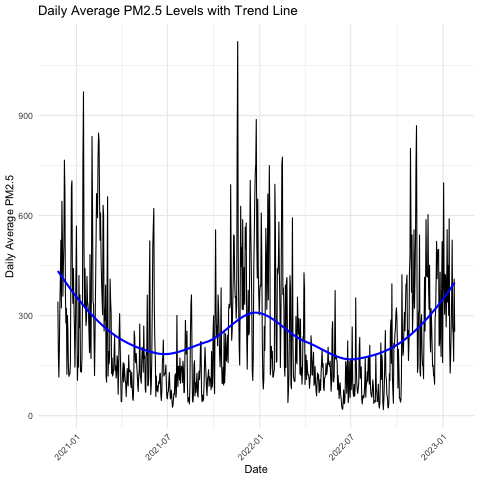

In [50]:
%%R
daily_data <- aggregate(pm2_5_values_all, by = list(as.Date(data$date)), FUN = mean)
colnames(daily_data) <- c("Date", "Daily_Avg_PM2_5")

# Plot with a LOESS smooth trend line
ggplot(daily_data, aes(x = Date, y = Daily_Avg_PM2_5)) +
  geom_line(color = "black", size = 0.5) +  # PM2.5 observations
  geom_smooth(method = "loess", color = "blue", size = 1, se = FALSE) +  # LOESS trend line
  labs(title = "Daily Average PM2.5 Levels with Trend Line",
       x = "Date", y = "Daily Average PM2.5") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

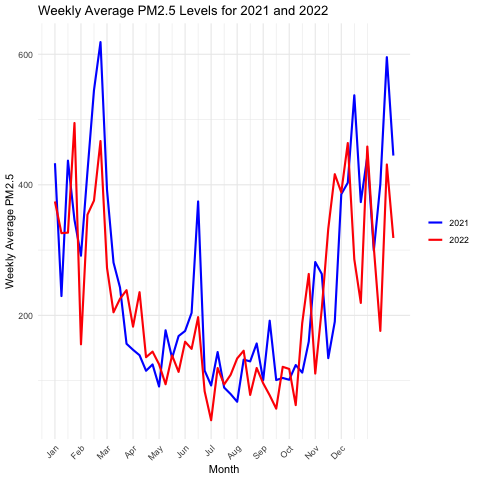

In [52]:
%%R
first_year_data <- data[as.Date(data$date) >= as.Date("2021-01-01") &
                                    as.Date(data$date) < as.Date("2022-01-01"), ]
first_year_data$Week <- floor_date(first_year_data$date, "week")
first_year_weekly_avg <- aggregate(first_year_data$pm2_5, by = list(first_year_data$Week), FUN = mean)
colnames(first_year_weekly_avg) <- c("Week", "Weekly_Avg_PM2_5")
first_year_weekly_avg$Relative_Week <- seq(1, nrow(first_year_weekly_avg))
first_year_weekly_avg$Year <- "2021"

# Filter data for the second year: 2022-01 to 2023-01
second_year_data <- data[as.Date(data$date) >= as.Date("2022-01-01") &
                                     as.Date(data$date) < as.Date("2023-01-01"), ]
second_year_data$Week <- floor_date(second_year_data$date, "week")
second_year_weekly_avg <- aggregate(second_year_data$pm2_5, by = list(second_year_data$Week), FUN = mean)
colnames(second_year_weekly_avg) <- c("Week", "Weekly_Avg_PM2_5")
second_year_weekly_avg$Relative_Week <- seq(1, nrow(second_year_weekly_avg))
second_year_weekly_avg$Year <- "2022"

# Combine the two datasets
combined_weekly_avg <- rbind(first_year_weekly_avg, second_year_weekly_avg)

# Define custom x-axis labels
month_labels <- c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
breaks <- seq(1, length(month_labels) * 4, by = 4)

# Plot the weekly averages for both years
ggplot(combined_weekly_avg, aes(x = Relative_Week, y = Weekly_Avg_PM2_5, color = Year, group = Year)) +
  geom_line(size = 1) +
  labs(title = "Weekly Average PM2.5 Levels for 2021 and 2022",
       x = "Month", y = "Weekly Average PM2.5") +
  theme_minimal() +
  scale_color_manual(values = c("2021" = "blue", "2022" = "red")) +
  scale_x_continuous(breaks = breaks, labels = month_labels) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.title = element_blank())

### 3.2. Log Data


	Augmented Dickey-Fuller Test

data:  monthly_data$Monthly_Log_Avg_PM2_5
Dickey-Fuller = -2.8016, Lag order = 8, p-value = 0.2665
alternative hypothesis: stationary



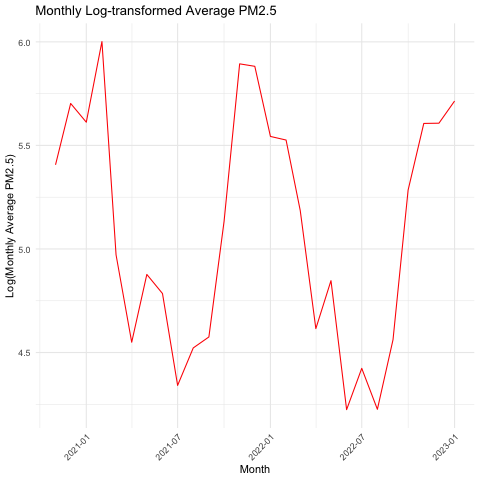

In [53]:
%%R
data$log_pm2_5 <- log(data$pm2_5)

# Original hourly data (log-transformed)
hourly_log_plot <- ggplot(data, aes(x = date, y = log_pm2_5)) +
  geom_line(color = "blue") +
  labs(title = "Hourly Log-transformed PM2.5 Observations", x = "Date", y = "Log(PM2.5)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Daily averages (log-transformed)
daily_data <- aggregate(log_pm2_5 ~ as.Date(date), data = data, FUN = mean)
colnames(daily_data) <- c("Date", "Daily_Log_Avg_PM2_5")
daily_log_plot <- ggplot(daily_data, aes(x = Date, y = Daily_Log_Avg_PM2_5)) +
  geom_line(color = "green") +
  labs(title = "Daily Log-transformed Average PM2.5", x = "Date", y = "Log(Daily Average PM2.5)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Weekly averages (log-transformed)
data$Week <- floor_date(data$date, "week")
weekly_data <- aggregate(log_pm2_5 ~ Week, data = data, FUN = mean)
colnames(weekly_data) <- c("Week", "Weekly_Log_Avg_PM2_5")
weekly_log_plot <- ggplot(weekly_data, aes(x = Week, y = Weekly_Log_Avg_PM2_5)) +
  geom_line(color = "orange") +
  labs(title = "Weekly Log-transformed Average PM2.5", x = "Week", y = "Log(Weekly Average PM2.5)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Monthly averages (log-transformed)
data$Month <- floor_date(data$date, "month")
monthly_data <- aggregate(log_pm2_5 ~ Month, data = data, FUN = mean)
colnames(monthly_data) <- c("Month", "Monthly_Log_Avg_PM2_5")
monthly_log_plot <- ggplot(monthly_data, aes(x = Month, y = Monthly_Log_Avg_PM2_5)) +
  geom_line(color = "red") +
  labs(title = "Monthly Log-transformed Average PM2.5", x = "Month", y = "Log(Monthly Average PM2.5)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Display all plots
print(hourly_log_plot)
print(daily_log_plot)
print(weekly_log_plot)
print(monthly_log_plot)

print(adf_monthly)

## 4. Block Maxima

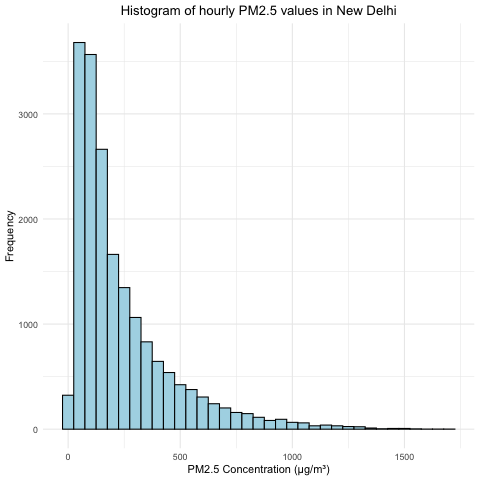

In [55]:
%%R
data <- data[ , c("date", "pm2_5")]
data$date <- as.Date(data$date, format = "%Y-%m-%d")

histo_pm2_5 <- ggplot(data, aes(x = pm2_5)) +
  geom_histogram(binwidth = 50, fill = "light blue", color = "black") +
  labs(title = "Histogram of hourly PM2.5 values in New Delhi",
       x = "PM2.5 Concentration (µg/m³)",
       y = "Frequency") +
   theme_minimal() +
   theme(plot.title = element_text(hjust = 0.5)) 

print(histo_pm2_5)

In [58]:
%%R
pm2_5_values <- data$pm2_5
pm2_5_positive <- data$pm2_5[data$pm2_5 > 0]

fit_gamma <- fitdist(pm2_5_positive, "gamma")
fit_weibull <- fitdist(pm2_5_positive, "weibull")
fit_exponential <- fitdist(pm2_5_positive, "exp")


histo_pm2_5_distr <- ggplot(data, aes(x = pm2_5)) +
  geom_histogram(aes(y = after_stat(density)), binwidth = 50, fill = "light blue", color = "black") +
  labs(title = "Histogram of hourly PM2.5 values in New Delhi with fitted distributions",
       x = "PM2.5 Concentration (µg/m³)",
       y = "Density") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

histo_pm2_5_distr +
  stat_function(fun = dgamma, args = list(shape = fit_gamma$estimate["shape"], rate = fit_gamma$estimate["rate"]), color = "red", linewidth = 1) +
  stat_function(fun = dweibull, args = list(shape = fit_weibull$estimate["shape"], scale = fit_weibull$estimate["scale"]), color = "green", linewidth = 1) +
  stat_function(fun = dexp, args = list(rate = fit_exponential$estimate["rate"]), color = "purple", linewidth = 1) +
  annotate("text", x = Inf, y = Inf, label = "Gamma = red\nWeibull = green\nExponential = purple", hjust = 1, vjust = 1, color = "black", size = 5, fontface = "bold")

gofstat(list(fit_gamma, fit_weibull, fit_exponential), fitnames = c("Gamma", "Weibull", "Exponential"))


Goodness-of-fit statistics
                                    Gamma      Weibull Exponential
Kolmogorov-Smirnov statistic   0.07000919   0.06512047   0.0905861
Cramer-von Mises statistic    29.17256248  26.02021100  31.3424644
Anderson-Darling statistic   161.97683783 170.27754329 263.8263874

Goodness-of-fit criteria
                                  Gamma  Weibull Exponential
Akaike's Information Criterion 241866.9 242382.7    243069.3
Bayesian Information Criterion 241882.6 242398.4    243077.1


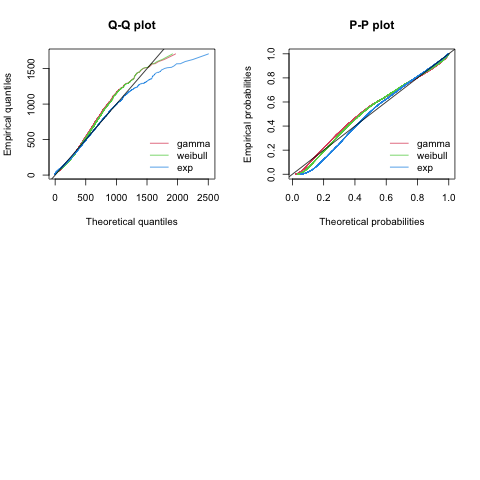

In [ ]:
%%R
par(mfrow = c(2, 2))
qqcomp(list(fit_gamma, fit_weibull, fit_exponential))
ppcomp(list(fit_gamma, fit_weibull, fit_exponential))

Caricamento del pacchetto richiesto: extRemes
Caricamento del pacchetto richiesto: Lmoments
Caricamento del pacchetto richiesto: distillery

Caricamento pacchetto: ‘extRemes’

Il seguente oggetto è mascherato da ‘package:vars’:

    fevd

I seguenti oggetti sono mascherati da ‘package:stats’:

    qqnorm, qqplot

In aggiunta: Messaggi di avvertimento:
1: In cov2cor(varcovar) :
  diag(V) had non-positive or NA entries; the non-finite result may be dubious
2: In sqrt(diag(varcovar)) : Si è prodotto un NaN


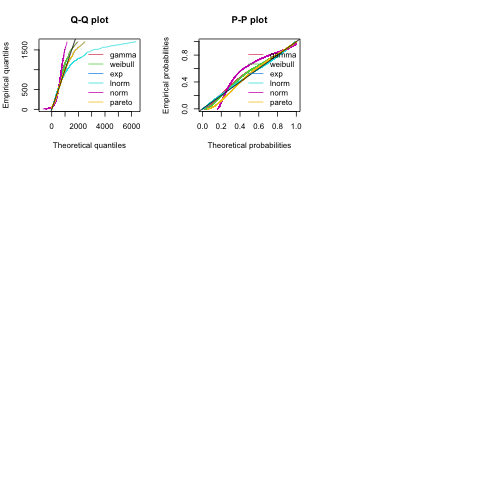

In [64]:
%%R
if (!require(actuar)) install.packages("actuar")
library(actuar)
if (!require(extRemes)) install.packages("extRemes")
library(extRemes)                                     

pm2_5_values <- data$pm2_5
pm2_5_positive <- pm2_5_values[pm2_5_values > 0]
fit_gamma <- fitdist(pm2_5_positive, "gamma")
fit_weibull <- fitdist(pm2_5_positive, "weibull")
fit_exponential <- fitdist(pm2_5_positive, "exp")
fit_lognormal <- fitdist(pm2_5_positive, "lnorm")
fit_normal <- fitdist(pm2_5_positive, "norm")
fit_pareto <- fitdist(pm2_5_positive, "pareto", start = list(shape = 1, scale = 1))
fit_gev <- fevd(pm2_5_positive, type = "GEV", method = "MLE")

# Create a histogram with the fitted distributions
histo_pm2_5_distr <- ggplot(data, aes(x = pm2_5)) +
  geom_histogram(aes(y = after_stat(density)), binwidth = 50, fill = "light blue", color = "black") +
  labs(title = "Histogram of hourly PM2.5 values in New Delhi with fitted distributions",
       x = "PM2.5 Concentration (µg/m³)",
       y = "Density") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

histo_pm2_5_distr +
  stat_function(fun = dgamma, args = list(shape = fit_gamma$estimate["shape"], rate = fit_gamma$estimate["rate"]), color = "red", linewidth = 1) +
  stat_function(fun = dweibull, args = list(shape = fit_weibull$estimate["shape"], scale = fit_weibull$estimate["scale"]), color = "green", linewidth = 1) +
  stat_function(fun = dexp, args = list(rate = fit_exponential$estimate["rate"]), color = "purple", linewidth = 1) +
  stat_function(fun = dlnorm, args = list(meanlog = fit_lognormal$estimate["meanlog"], sdlog = fit_lognormal$estimate["sdlog"]), color = "orange", linewidth = 1) +
  stat_function(fun = dnorm, args = list(mean = fit_normal$estimate["mean"], sd = fit_normal$estimate["sd"]), color = "blue", linewidth = 1) +
  stat_function(fun = dpareto, args = list(shape = fit_pareto$estimate["shape"], scale = fit_pareto$estimate["scale"]), color = "brown", linewidth = 1) +
  annotate("text", x = Inf, y = Inf, label = "Gamma = red\nWeibull = green\nExponential = purple\nLog-normal = orange\nNormal = blue\nPareto = brown",
           hjust = 1, vjust = 1, color = "black", size = 5, fontface = "bold")

# To find out which distribution fits the data the best
gofstat(list(fit_gamma, fit_weibull, fit_exponential, fit_lognormal, fit_normal, fit_pareto),
        fitnames = c("Gamma", "Weibull", "Exponential", "Log-normal", "Normal", "Pareto"))

# QQ plots to visually assess goodness of fit
par(mfrow = c(3, 3)) # Set up the plot area for multiple plots
qqcomp(list(fit_gamma, fit_weibull, fit_exponential, fit_lognormal, fit_normal, fit_pareto))

# PP plots to further assess the goodness of fit
ppcomp(list(fit_gamma, fit_weibull, fit_exponential, fit_lognormal, fit_normal, fit_pareto))

We extracted the weekly maximum values and created their histogram, identifying the distribution that best fits the data.

In [65]:
%%R
data$date <- as.Date(data$date, format = "%Y-%m-%d")

# Extract the year and week from the date column
data$Year <- format(data$date, "%Y")
data$Week <- format(data$date, "%U") # Week number (00-53)

# Combine Year and Week to create a unique week identifier
data$Year_Week <- paste0(data$Year, "-", data$Week)

# Group by the unique Year_Week identifier to calculate the maximum PM2.5 value for each week
weekly_max <- data %>%
  group_by(Year_Week) %>%
  summarize(Week_Start_Date = min(date), Max_PM2_5 = max(pm2_5, na.rm = TRUE), .groups = "drop") # .groups = "drop" avoids unnecessary grouping warnings

# Add a continuous week index for modeling
weekly_max <- weekly_max %>%
  arrange(Week_Start_Date) %>%
  mutate(Week_Index = row_number())

# View the weekly maximum values
print(weekly_max)

# A tibble: 116 × 4
   Year_Week Week_Start_Date Max_PM2_5 Week_Index
   <chr>     <date>              <dbl>      <int>
 1 2020-47   2020-11-25           464.          1
 2 2020-48   2020-11-29          1229.          2
 3 2020-49   2020-12-06          1121.          3
 4 2020-50   2020-12-13           669.          4
 5 2020-51   2020-12-20          1121.          5
 6 2020-52   2020-12-27           791.          6
 7 2021-00   2021-01-01           999.          7
 8 2021-01   2021-01-03          1161.          8
 9 2021-02   2021-01-10          1500.          9
10 2021-03   2021-01-17           940.         10
# ℹ 106 more rows
# ℹ Use `print(n = ...)` to see more rows


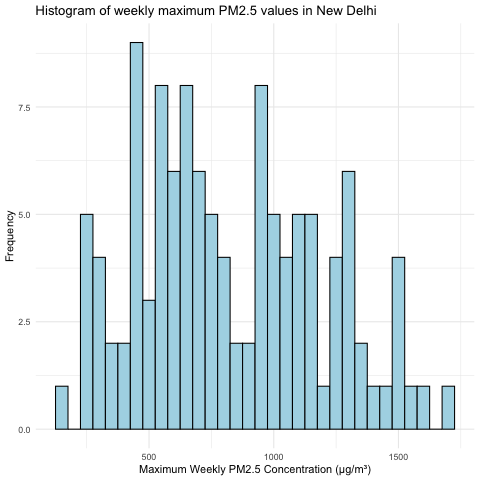

In [66]:
%%R
histo_weekly_max <- ggplot(weekly_max, aes(x = Max_PM2_5)) +
  geom_histogram(binwidth = 50, fill = "light blue", color = "black") + 
  labs(title = "Histogram of weekly maximum PM2.5 values in New Delhi",
       x = "Maximum Weekly PM2.5 Concentration (µg/m³)",
       y = "Frequency") +
  theme_minimal()

print(histo_weekly_max)

In [67]:
%%R
Max_PM2_5 <- weekly_max$Max_PM2_5
fit_normal <- fitdist(Max_PM2_5, "norm")
fit_gamma <- fitdist(Max_PM2_5, "gamma")
fit_lognormal <- fitdist(Max_PM2_5, "lnorm")


fit_pareto <- fitdist(Max_PM2_5, "pareto", start = list(shape = 1, scale = 1))
fit_gev <- fevd(Max_PM2_5, type = "GEV")
summary(fit_normal)
summary(fit_gamma)
summary(fit_lognormal)
summary(fit_pareto)
summary(fit_gev)


fevd(x = Max_PM2_5, type = "GEV")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  847.2743 


 Estimated parameters:
   location       scale       shape 
677.7442733 338.4806816  -0.1834283 

 Standard Error Estimates:
  location      scale      shape 
36.4538416 27.4997580  0.0882488 

 Estimated parameter covariance matrix.
            location      scale       shape
location 1328.882567 249.780011 -1.46975374
scale     249.780011 756.236691 -1.45241675
shape      -1.469754  -1.452417  0.00778785

 AIC = 1700.549 

 BIC = 1708.809 


In aggiunta: Messaggio di avvertimento:
Computation failed in `stat_function()`.
Caused by error in `dgev()`:
! non trovo la funzione "dgev" 


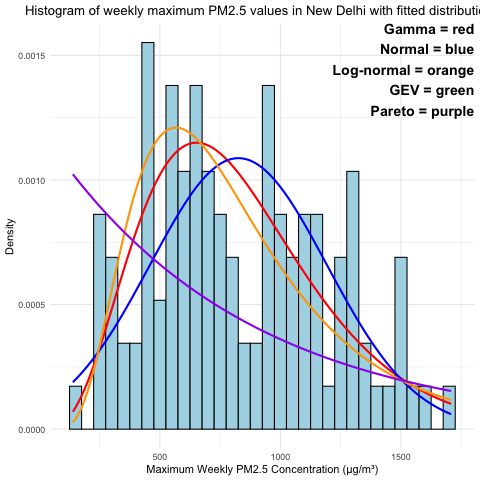

In [68]:
%%R
histo_weekly_max_distr <- ggplot(weekly_max, aes(x = Max_PM2_5)) +
  geom_histogram(aes(y = after_stat(density)), binwidth = 50, fill = "light blue", color = "black") + # Adjusted binwidth for weekly data
  labs(title = "Histogram of weekly maximum PM2.5 values in New Delhi with fitted distributions",
       x = "Maximum Weekly PM2.5 Concentration (µg/m³)",
       y = "Density") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# Add the fitted distribution curves
histo_weekly_max_distr <- histo_weekly_max_distr +
  stat_function(fun = dgamma, args = list(shape = fit_gamma$estimate["shape"], rate = fit_gamma$estimate["rate"]), color = "red", linewidth = 1) +
  stat_function(fun = dnorm, args = list(mean = fit_normal$estimate["mean"], sd = fit_normal$estimate["sd"]), color = "blue", linewidth = 1) +
  stat_function(fun = dlnorm, args = list(meanlog = fit_lognormal$estimate["meanlog"], sdlog = fit_lognormal$estimate["sdlog"]), color = "orange", linewidth = 1) +
  stat_function(fun = function(x) dgev(x, loc = fit_gev$results$par["location"], scale = fit_gev$results$par["scale"], shape = fit_gev$results$par["shape"]), color = "green", linewidth = 1) +
  stat_function(fun = dpareto, args = list(shape = fit_pareto$estimate["shape"], scale = fit_pareto$estimate["scale"]), color = "purple", linewidth = 1) +
  annotate("text", x = Inf, y = Inf, label = "Gamma = red\nNormal = blue\nLog-normal = orange\nGEV = green\nPareto = purple",
           hjust = 1, vjust = 1, color = "black", size = 5, fontface = "bold")

# Print the histogram with fitted distributions
print(histo_weekly_max_distr)

In [69]:
%%R
if (!require(POT)) install.packages("POT")
library(POT)

gof_results <- gofstat(list(fit_normal, fit_gamma, fit_lognormal, fit_pareto),
                       fitnames = c("Normal", "Gamma", "Log-normal", "Pareto"))

AIC_BIC <- data.frame(
  Distribution = c("Normal", "Gamma", "Log-normal", "Pareto"),
  AIC = gof_results$aic,
  BIC = gof_results$bic
)
print(AIC_BIC)
str(fit_gev)

logLik_gev <- fit_gev$results$value
params_gev <- length(fit_gev$results$par)

print(paste("Log-likelihood for GEV:", logLik_gev))
print(paste("Number of parameters for GEV:", params_gev))

AIC_GEV <- 2 * params_gev - 2 * logLik_gev
print(paste("AIC for GEV:", AIC_GEV))

AIC_BIC <- rbind(AIC_BIC, data.frame(Distribution = "GEV", AIC = AIC_GEV, BIC = NA))
print(AIC_BIC)

           Distribution      AIC      BIC
Normal           Normal 1703.090 1708.598
Gamma             Gamma 1699.366 1704.873
Log-normal   Log-normal 1708.607 1714.114
Pareto           Pareto 1794.136 1799.643
List of 18
 $ call           : language fevd(x = Max_PM2_5, type = "GEV")
 $ data.name      : chr [1:2] "Max_PM2_5" ""
 $ weights        : num 1
 $ missing.values : logi [1:116] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ in.data        : logi FALSE
 $ x              : num [1:116] 464 1229 1121 669 1121 ...
 $ method         : chr "MLE"
 $ type           : chr "GEV"
 $ period.basis   : chr "year"
 $ par.models     :List of 6
  ..$ threshold :Class 'formula'  language ~1
  .. .. ..- attr(*, ".Environment")=<environment: 0x128be67e0> 
  ..$ location  :Class 'formula'  language ~1
  .. .. ..- attr(*, ".Environment")=<environment: 0x128be67e0> 
  ..$ scale     :Class 'formula'  language ~1
  .. .. ..- attr(*, ".Environment")=<environment: 0x128be67e0> 
  ..$ log.scale : logi FALSE
  .

Caricamento del pacchetto richiesto: POT

Caricamento pacchetto: ‘POT’

Il seguente oggetto è mascherato da ‘package:extRemes’:

    mrlplot



Caricamento del pacchetto richiesto: evd
Registered S3 methods overwritten by 'evd':
  method      from
  print.bvpot POT 
  plot.bvpot  POT 

Caricamento pacchetto: ‘evd’

I seguenti oggetti sono mascherati da ‘package:POT’:

    dens, dgpd, exiplot, mrlplot, pgpd, pp, qgpd, qq, rgpd, tcplot

Il seguente oggetto è mascherato da ‘package:extRemes’:

    mrlplot

I seguenti oggetti sono mascherati da ‘package:actuar’:

    dgumbel, pgumbel, qgumbel, rgumbel

In aggiunta: Messaggio di avvertimento:
In int_abline(a = a, b = b, h = h, v = v, untf = untf, ...) :
  parametro grafico "args" non valido


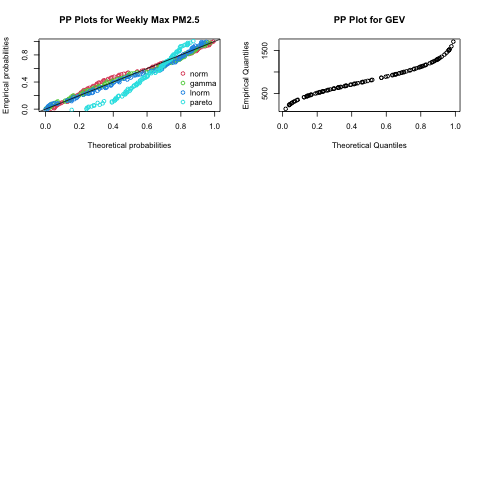

In [71]:
%%R
if (!require(evd)) install.packages("evd")
library(evd)

par(mfrow = c(3, 2))
qqcomp(list(fit_normal, fit_gamma, fit_lognormal, fit_pareto), main = "QQ Plots for Weekly Max PM2.5")

qqnorm(weekly_max$Max_PM2_5, main = "QQ Plot for GEV")
qqline(weekly_max$Max_PM2_5, distribution = qgev,
       args = list(loc = fit_gev$results$par["location"],
                   scale = fit_gev$results$par["scale"],
                   shape = fit_gev$results$par["shape"]),
       col = "green")

par(mfrow = c(3, 2)) 
ppcomp(list(fit_normal, fit_gamma, fit_lognormal, fit_pareto), main = "PP Plots for Weekly Max PM2.5")

ppoints <- ppoints(length(weekly_max$Max_PM2_5))
gev_probs <- pgev(sort(weekly_max$Max_PM2_5),
                  loc = fit_gev$results$par["location"],
                  scale = fit_gev$results$par["scale"],
                  shape = fit_gev$results$par["shape"])
plot(gev_probs, sort(weekly_max$Max_PM2_5), main = "PP Plot for GEV", xlab = "Theoretical Quantiles", ylab = "Empirical Quantiles")
abline(0, 1, col = "green")

We fitted a linear model to the weekly maximum precipitation values, predicted the values for the next 20 weeks, provided confidence intervals for these predictions, and plotted the results. We also evaluated whether this is a reasonable approach.

'data.frame':	52 obs. of  4 variables:
 $ Week_Index: int  117 118 119 120 121 122 123 124 125 126 ...
 $ fit       : num  804 803 803 802 802 ...
 $ lwr       : num  667 665 662 660 658 ...
 $ upr       : num  940 942 943 945 946 ...
   Week_Index      fit      lwr       upr
1         117 803.5481 666.6468  940.4494
2         118 803.1713 664.5037  941.8389
3         119 802.7945 662.3534  943.2356
4         120 802.4177 660.1962  944.6392
5         121 802.0409 658.0323  946.0494
6         122 801.6641 655.8621  947.4660
7         123 801.2872 653.6857  948.8888
8         124 800.9104 651.5034  950.3175
9         125 800.5336 649.3153  951.7519
10        126 800.1568 647.1218  953.1918
11        127 799.7800 644.9229  954.6371
12        128 799.4032 642.7189  956.0875
13        129 799.0264 640.5099  957.5428
14        130 798.6496 638.2961  959.0030
15        131 798.2727 636.0777  960.4678
16        132 797.8959 633.8549  961.9370
17        133 797.5191 631.6277  963.4106
18       

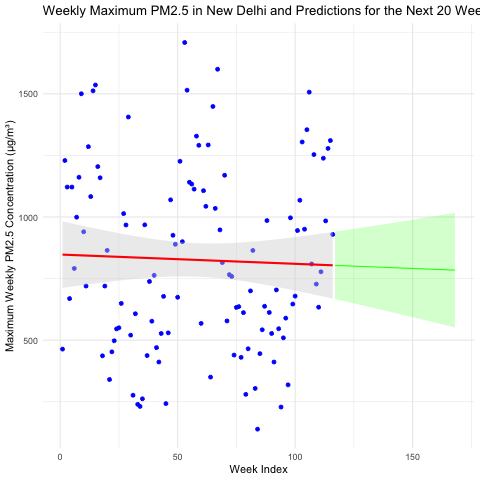

In [72]:
%%R
weekly_max <- weekly_max %>%
  arrange(Week_Start_Date) # Ensure data is ordered by week start date

# Fit a linear model to the weekly maximum PM2.5 values
linear_model <- lm(Max_PM2_5 ~ Week_Index, data = weekly_max)

# Summary of the linear model
summary(linear_model)

# Create a new data frame for the next 20 weeks
last_week_index <- max(weekly_max$Week_Index)
future_weeks <- data.frame(Week_Index = (last_week_index + 1):(last_week_index + 52))

# Predict values for the next 20 weeks with confidence intervals
predictions <- predict(linear_model, newdata = future_weeks, interval = "confidence", level = 0.95)

# Combine the future weeks with predictions
future_weeks <- cbind(future_weeks, predictions)
names(future_weeks) <- c("Week_Index", "fit", "lwr", "upr")

# Check the structure of future_weeks
str(future_weeks)
print(future_weeks)

# Plot the results
ggplot() +
  geom_point(data = weekly_max, aes(x = Week_Index, y = Max_PM2_5), color = "blue") +
  geom_smooth(data = weekly_max, aes(x = Week_Index, y = Max_PM2_5), method = "lm", se = TRUE, color = "red", fill = "lightgray") +
  geom_line(data = future_weeks, aes(x = Week_Index, y = fit), color = "green") +
  geom_ribbon(data = future_weeks, aes(x = Week_Index, ymin = lwr, ymax = upr), alpha = 0.2, fill = "green") +
  labs(title = "Weekly Maximum PM2.5 in New Delhi and Predictions for the Next 20 Weeks",
       x = "Week Index",
       y = "Maximum Weekly PM2.5 Concentration (µg/m³)") +
  theme_minimal()

We fitted a GEV model with constant parameters to the historical weekly maximum values, using the fevd function from the extRemes library or the gev.fit function from the ismev library. We also fitted a second GEV model with a time-varying location parameter and compared the two models using AIC or BIC. Based on the comparison, we identified the model we recommend using.

In [73]:
%%R
str(weekly_max)
length(weekly_max$Max_PM2_5) == nrow(weekly_max)

tibble [116 × 4] (S3: tbl_df/tbl/data.frame)
 $ Year_Week      : chr [1:116] "2020-47" "2020-48" "2020-49" "2020-50" ...
 $ Week_Start_Date: Date[1:116], format: "2020-11-25" "2020-11-29" ...
 $ Max_PM2_5      : num [1:116] 464 1229 1121 669 1121 ...
 $ Week_Index     : int [1:116] 1 2 3 4 5 6 7 8 9 10 ...
[1] TRUE


In [75]:
%%R
if (!require(ismev)) install.packages("ismev")
library(ismev)

gev_constant <- fevd(weekly_max$Max_PM2_5, type = "GEV")
print(summary(gev_constant))

gev_varying_loc <- fevd(Max_PM2_5 ~ Week_Index, data = weekly_max, type = "GEV")
print(summary(gev_varying_loc))

logLik_constant <- gev_constant$results$value
logLik_varying_loc <- gev_varying_loc$results$value

params_constant <- length(gev_constant$results$par)
params_varying_loc <- length(gev_varying_loc$results$par)

AIC_constant <- 2 * params_constant - 2 * logLik_constant
AIC_varying_loc <- 2 * params_varying_loc - 2 * logLik_varying_loc

print(paste("AIC for GEV with constant parameters:", AIC_constant))
print(paste("AIC for GEV with time-varying location parameter:", AIC_varying_loc))


fevd(x = weekly_max$Max_PM2_5, type = "GEV")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  847.2743 


 Estimated parameters:
   location       scale       shape 
677.7442733 338.4806816  -0.1834283 

 Standard Error Estimates:
  location      scale      shape 
36.4538416 27.4997580  0.0882488 

 Estimated parameter covariance matrix.
            location      scale       shape
location 1328.882567 249.780011 -1.46975374
scale     249.780011 756.236691 -1.45241675
shape      -1.469754  -1.452417  0.00778785

 AIC = 1700.549 

 BIC = 1708.809 
$par
   location       scale       shape 
677.7442733 338.4806816  -0.1834283 

$cov.theta
            location      scale       shape
location 1328.882567 249.780011 -1.46975374
scale     249.780011 756.236691 -1.45241675
shape      -1.469754  -1.452417  0.00778785

$se.theta
  location      scale      shape 
36.4538416 27.4997580  0.0882488 

$nllh
[1] 847.2743

$AIC
[1] 1700.549

$BIC
[1] 1708.809


fevd(x = Max_PM2_5 ~

Caricamento del pacchetto richiesto: ismev
Caricamento del pacchetto richiesto: mgcv
Caricamento del pacchetto richiesto: nlme

Caricamento pacchetto: ‘nlme’

Il seguente oggetto è mascherato da ‘package:forecast’:

    getResponse

Il seguente oggetto è mascherato da ‘package:dplyr’:

    collapse

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


In [76]:
%%R
gev_constant <- fevd(weekly_max$Max_PM2_5, method = "MLE", type = "GEV")
print(summary(gev_constant))

gev_varying_loc <- fevd(weekly_max$Max_PM2_5, method = "MLE", type = "GEV", loc = ~as.numeric(weekly_max$Week_Index))
print(summary(gev_varying_loc))


fevd(x = weekly_max$Max_PM2_5, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  847.2743 


 Estimated parameters:
   location       scale       shape 
677.7442733 338.4806816  -0.1834283 

 Standard Error Estimates:
  location      scale      shape 
36.4538416 27.4997580  0.0882488 

 Estimated parameter covariance matrix.
            location      scale       shape
location 1328.882567 249.780011 -1.46975374
scale     249.780011 756.236691 -1.45241675
shape      -1.469754  -1.452417  0.00778785

 AIC = 1700.549 

 BIC = 1708.809 
$par
   location       scale       shape 
677.7442733 338.4806816  -0.1834283 

$cov.theta
            location      scale       shape
location 1328.882567 249.780011 -1.46975374
scale     249.780011 756.236691 -1.45241675
shape      -1.469754  -1.452417  0.00778785

$se.theta
  location      scale      shape 
36.4538416 27.4997580  0.0882488 

$nllh
[1] 847.2743

$AIC
[1] 1700.549

$BIC
[1] 1708.809


fevd

In [77]:
%%R
max_pm2_5 <- weekly_max$Max_PM2_5
gev_fit <- fevd(max_pm2_5, type = "GEV")
summary(gev_fit)


fevd(x = max_pm2_5, type = "GEV")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  847.2743 


 Estimated parameters:
   location       scale       shape 
677.7442733 338.4806816  -0.1834283 

 Standard Error Estimates:
  location      scale      shape 
36.4538416 27.4997580  0.0882488 

 Estimated parameter covariance matrix.
            location      scale       shape
location 1328.882567 249.780011 -1.46975374
scale     249.780011 756.236691 -1.45241675
shape      -1.469754  -1.452417  0.00778785

 AIC = 1700.549 

 BIC = 1708.809 


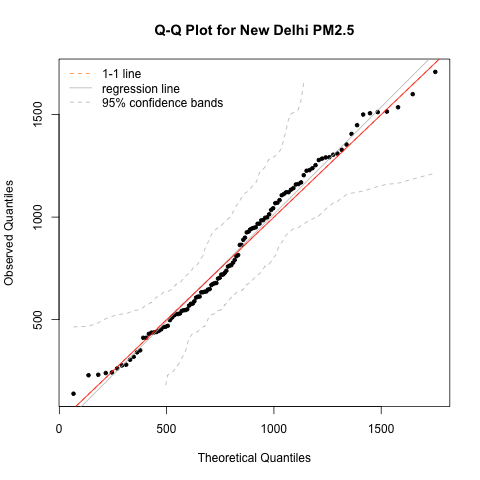

In [78]:
%%R
fitted_params <- c(677.7442733, 338.4806816, -0.1834283)  
max_pm2_5 <- weekly_max$Max_PM2_5

theoretical_quantiles <- gevq(fitted_params, 1 - (1:length(max_pm2_5) / (length(max_pm2_5) + 1)))

valid_indices <- which(!is.na(theoretical_quantiles) & is.finite(theoretical_quantiles))
valid_theoretical <- theoretical_quantiles[valid_indices]
valid_observed <- sort(max_pm2_5[valid_indices])

qqplot(valid_theoretical, valid_observed, main = "Q-Q Plot for New Delhi PM2.5",
       xlab = "Theoretical Quantiles", ylab = "Observed Quantiles")
abline(0, 1, col = "red") 

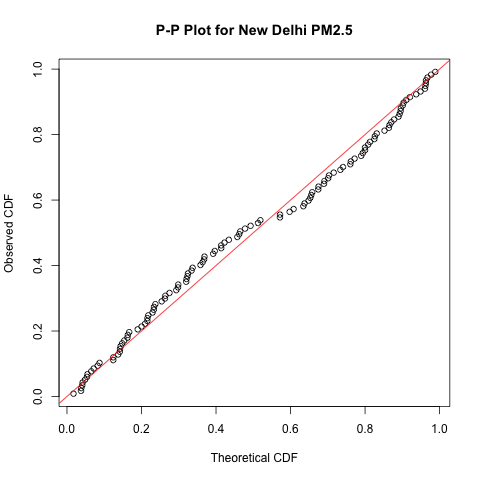

In [79]:
%%R
fitted_params <- c(677.7442733, 338.4806816, -0.1834283) 
max_pm2_5 <- weekly_max$Max_PM2_5

observed_cdf <- (1:length(max_pm2_5)) / (length(max_pm2_5) + 1)
theoretical_cdf <- pgev(sort(max_pm2_5), loc = fitted_params[1], scale = fitted_params[2], shape = fitted_params[3])

plot(theoretical_cdf, observed_cdf, main = "P-P Plot for New Delhi PM2.5",
     xlab = "Theoretical CDF", ylab = "Observed CDF")
abline(0, 1, col = "red")

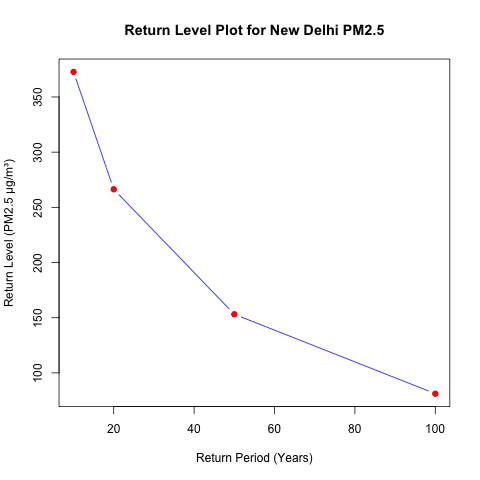

In [80]:
%%R
fitted_params <- c(677.7442733, 338.4806816, -0.1834283)
return_periods <- c(10, 20, 50, 100)
return_levels <- gevq(fitted_params, 1 - 1 / return_periods)
plot(return_periods, return_levels, type = "b", pch = 16, col = "blue",
     main = "Return Level Plot for New Delhi PM2.5",
     xlab = "Return Period (Years)", ylab = "Return Level (PM2.5 µg/m³)")
points(return_periods, return_levels, col = "red", pch = 19) 

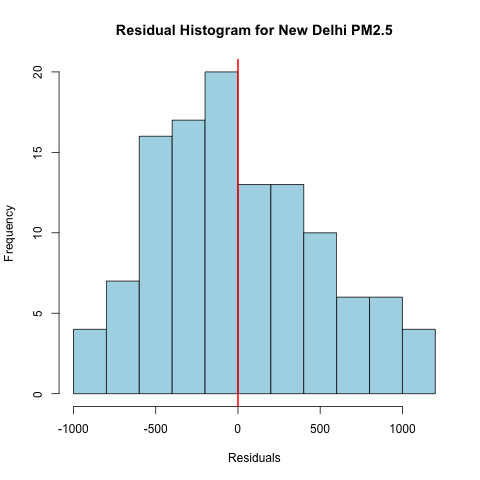

In [81]:
%%R
fitted_params <- c(677.7442733, 338.4806816, -0.1834283) 
max_pm2_5 <- weekly_max$Max_PM2_5

residuals <- max_pm2_5 - gevq(fitted_params, 1 - (1:length(max_pm2_5) / (length(max_pm2_5) + 1)))
hist(residuals, breaks = 10, col = "lightblue", main = "Residual Histogram for New Delhi PM2.5",
     xlab = "Residuals", ylab = "Frequency")
abline(v = 0, col = "red", lwd = 2)  

$conv
[1] 0

$nllh
[1] 847.2708

$mle
[1] 679.9053501 337.2067531  -0.1827308

$se
[1] 36.465439 27.080572  0.087716



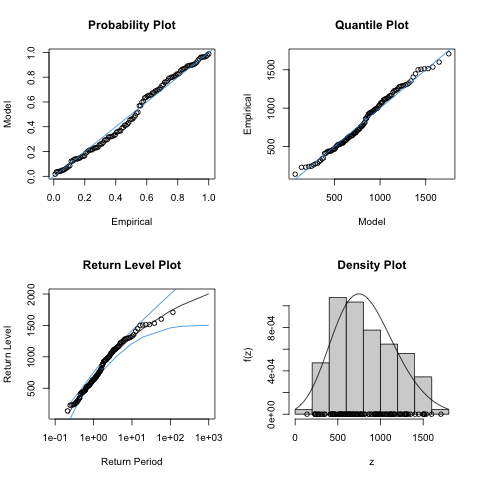

In [82]:
%%R
max_pm2_5 <- weekly_max$Max_PM2_5
gev_fit <- gev.fit(max_pm2_5)
gev.diag(gev_fit)

Using the model selected in the previous parts, we predicted the 52-week return level and visualized the predictions alongside the observed data.

$conv
[1] 0

$nllh
[1] 847.2708

$mle
[1] 679.9053501 337.2067531  -0.1827308

$se
[1] 36.465439 27.080572  0.087716

[1] "52-Week Return Level: 1627.25752292457"


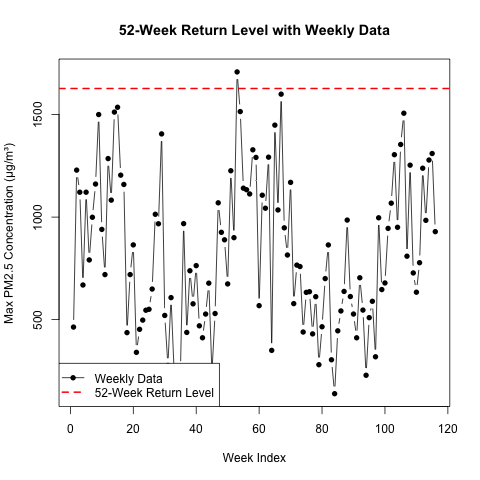

In [83]:
%%R
max_pm2_5 <- weekly_max$Max_PM2_5
gev_fit <- gev.fit(max_pm2_5)
fitted_params <- gev_fit$mle

return_period <- 52
return_level_52_week <- fitted_params[1] +
  (fitted_params[2] / fitted_params[3]) *
  ((-log(1 - 1 / return_period))^(-fitted_params[3]) - 1)

print(paste("52-Week Return Level:", return_level_52_week))

weeks <- seq_along(max_pm2_5)  
pm2_5_data <- max_pm2_5  

plot(weeks, pm2_5_data, type = "b", pch = 16, col = "black",
     main = "52-Week Return Level with Weekly Data",
     xlab = "Week Index", ylab = "Max PM2.5 Concentration (µg/m³)")

abline(h = return_level_52_week, col = "red", lwd = 2, lty = 2)
legend("bottomleft", legend = c("Weekly Data", "52-Week Return Level"),
       col = c("black", "red"), lty = c(1, 2), pch = c(16, NA), lwd = c(1, 2))

We commented on the results obtained from both the linear model prediction (from c) and the GEV approach (from f). Additionally, we analyzed how many historical values exceeded the 52-week return level and extended this analysis to include the 104, 260, and 442-week return levels.

Return levels for each period:
 52-week return level 104-week return level 260-week return level 
             1627.525              1735.147              1857.396 
442-week return level 
             1919.220 

Number of historical exceedances for each period:
 52-week exceedances 104-week exceedances 260-week exceedances 
                   1                    0                    0 
442-week exceedances 
                   0 


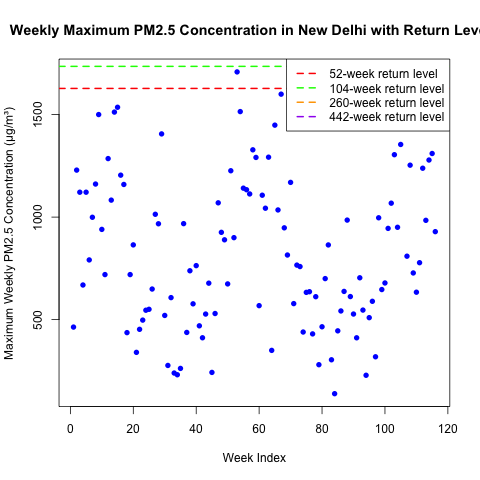

In [84]:
%%R
location <- 677.7442733
scale <- 338.4806816
shape <- -0.1834283

return_periods <- c(52, 104, 260, 442) 
probabilities <- 1 - 1 / return_periods

return_levels <- location + (scale / shape) * ((-log(probabilities))^(-shape) - 1)
names(return_levels) <- paste(return_periods, "-week return level", sep = "")

cat("Return levels for each period:\n")
print(return_levels)

historical_data <- weekly_max$Max_PM2_5 

exceedances <- sapply(return_levels, function(level) sum(historical_data > level))
names(exceedances) <- paste(return_periods, "-week exceedances", sep = "")

cat("\nNumber of historical exceedances for each period:\n")
print(exceedances)

plot(weekly_max$Week_Index, historical_data, type = "p", col = "blue", pch = 16,
     main = "Weekly Maximum PM2.5 Concentration in New Delhi with Return Levels",
     xlab = "Week Index", ylab = "Maximum Weekly PM2.5 Concentration (µg/m³)")
abline(h = return_levels, col = c("red", "green", "orange", "purple"), lty = 2, lwd = 2)
legend("topright", legend = names(return_levels), col = c("red", "green", "orange", "purple"),
       lty = 2, lwd = 2)

Using the fitted model, we computed the return period associated with 2000 µg/m³ of PM2.5 pollution.

In [85]:
%%R
location <- 677.7442733  
scale <- 338.4806816     
shape <- -0.1834283   

threshold <- 2000 

prob <- pgev(threshold, loc = location, scale = scale, shape = shape)
return_period <- 1 / (1 - prob) 

# Print the result
cat("The return period for a PM2.5 concentration of", threshold, "µg/m³ is approximately", round(return_period, 2), "weeks.\n")

The return period for a PM2.5 concentration of 2000 µg/m³ is approximately 966.47 weeks.


Using the fitted model, we calculated the probability of having at least one day in the next year where the PM2.5 concentration exceeds 2500 µg/m³.

In [86]:
%%R
location <- 677.7442733
scale <- 338.4806816
shape <- -0.1834283

threshold <- 2500
weekly_exceedance_prob <- 1 - pgev(threshold, loc = location, scale = scale, shape = shape)
year_prob <- 1 - (1 - weekly_exceedance_prob)^52

print(paste("Weekly exceedance probability:", weekly_exceedance_prob))
print(paste("Probability of at least one exceedance in the next year:", year_prob))

[1] "Weekly exceedance probability: 4.1963321706362e-11"
[1] "Probability of at least one exceedance in the next year: 2.18209272873082e-09"


## 5. Peaks-over-Threshold (with Clustering and Seasonal Variation)

**Main Objetives**:
Identify extreme PM2.5 events:
- Subset the daily maximum PM2.5 levels from the dataset.
- Determine a high threshold (e.g., the 95th percentile) to classify extreme events.

Model the extreme data:
- Fit a Generalized Pareto Distribution (GPD) to the exceedances above the chosen threshold.

Account for clustering of extremes:
- Calculate the extremal index to determine whether extremes occur in clusters.
- Decluster the data to model independent extreme events.

Make predictions:
- Compute return levels for specified return periods (e.g., 10, 20, 50 years).



### 5.1. Data Exploration

In [106]:
%%R
if (!require(ismev)) install.packages("ismev")
if (!require(dplyr)) install.packages("dplyr")
if (!require(ggplot2)) install.packages("ggplot2")
if (!require(extRemes)) install.packages("extRemes")
if (!require(evd)) install.packages("evd")
library(ismev)
library(dplyr)
library(ggplot2)
library(extRemes)
library(evd)

data <- read.csv("Data/delhi_aqi.csv")
data$date <- as.POSIXct(data$date, format = "%Y-%m-%d %H:%M:%S")

In [107]:
%%R
head(data)

                 date      co    no    no2    o3    so2  pm2_5   pm10   nh3
1 2020-11-25 01:00:00 2616.88  2.18  70.60 13.59  38.62 364.61 411.73 28.63
2 2020-11-25 02:00:00 3631.59 23.25  89.11  0.33  54.36 420.96 486.21 41.04
3 2020-11-25 03:00:00 4539.49 52.75 100.08  1.11  68.67 463.68 541.95 49.14
4 2020-11-25 04:00:00 4539.49 50.96 111.04  6.44  78.20 454.81 534.00 48.13
5 2020-11-25 05:00:00 4379.27 42.92 117.90 17.17  87.74 448.14 529.19 46.61
6 2020-11-25 06:00:00 3898.62 28.39 117.90 40.05 101.09 437.25 511.79 42.05


In [108]:
%%R
str(data)

'data.frame':	18776 obs. of  9 variables:
 $ date : POSIXct, format: "2020-11-25 01:00:00" "2020-11-25 02:00:00" ...
 $ co   : num  2617 3632 4539 4539 4379 ...
 $ no   : num  2.18 23.25 52.75 50.96 42.92 ...
 $ no2  : num  70.6 89.1 100.1 111 117.9 ...
 $ o3   : num  13.59 0.33 1.11 6.44 17.17 ...
 $ so2  : num  38.6 54.4 68.7 78.2 87.7 ...
 $ pm2_5: num  365 421 464 455 448 ...
 $ pm10 : num  412 486 542 534 529 ...
 $ nh3  : num  28.6 41 49.1 48.1 46.6 ...


In [109]:
%%R
colSums(is.na(data))

 date    co    no   no2    o3   so2 pm2_5  pm10   nh3 
    2     0     0     0     0     0     0     0     0 


In [110]:
%%R
dim(data)

[1] 18776     9


In [111]:
%%R
summary(data)

      date                              co                no        
 Min.   :2020-11-25 01:00:00.00   Min.   :  260.4   Min.   :  0.00  
 1st Qu.:2021-06-09 15:15:00.00   1st Qu.: 1068.1   1st Qu.:  0.68  
 Median :2021-12-22 04:30:00.00   Median : 1842.5   Median :  5.25  
 Mean   :2021-12-23 14:16:01.06   Mean   : 2929.2   Mean   : 33.66  
 3rd Qu.:2022-07-07 18:45:00.00   3rd Qu.: 3685.0   3rd Qu.: 35.76  
 Max.   :2023-01-24 08:00:00.00   Max.   :21148.7   Max.   :500.68  
 NA's   :2                                                          
      no2               o3              so2             pm2_5        
 Min.   :  4.28   Min.   :  0.00   Min.   :  5.25   Min.   :  11.83  
 1st Qu.: 33.93   1st Qu.:  0.34   1st Qu.: 34.81   1st Qu.:  84.44  
 Median : 54.15   Median : 27.18   Median : 52.93   Median : 157.44  
 Mean   : 66.22   Mean   : 60.35   Mean   : 66.69   Mean   : 238.13  
 3rd Qu.: 83.63   3rd Qu.: 92.98   3rd Qu.: 82.02   3rd Qu.: 313.00  
 Max.   :460.62   Max.   :80

We focus just in the variable `pm2_5`.

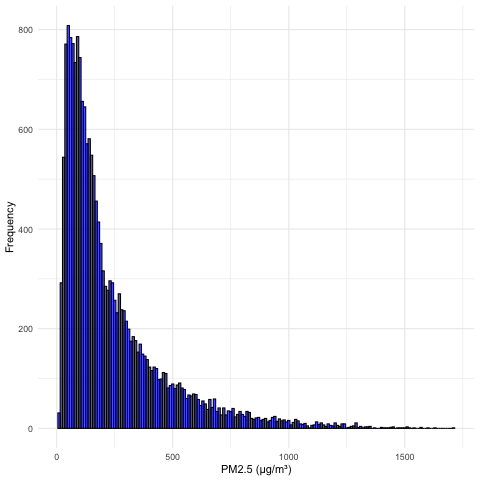

In [112]:
%%R
#Histogram of PM 2.5 levels
ggplot(data, aes(x = pm2_5)) +
  geom_histogram(binwidth = 10, fill = "blue", color = "black", alpha = 0.7) +
  labs(
    x = "PM2.5 (µg/m³)",
    y = "Frequency"
  ) +
  theme_minimal()

The histogram of PM2.5 levels shows a strong right-skewed distribution, with most of values concentrated at lower levels, particularly between 0 and 200 µg/m³. This indicates that low-to-moderate pollution levels occur frequently. However, the presence of a long tail extending beyond 1000 µg/m³ highlights the occurrence of rare but extreme pollution events. These extreme values, while infrequent, suggest significant episodes of severe air quality deterioration that warrant further investigation. 

### 5.2. Identify Extreme Events

In [113]:
%%R
daily_max <- data %>%
  group_by(Date = as.Date(date)) %>%
  summarize(Daily_Max_PM2_5 = max(pm2_5, na.rm = TRUE))

daily_max$Date <- as.Date(daily_max$Date)

print(daily_max)

# A tibble: 785 × 2
   Date       Daily_Max_PM2_5
   <date>               <dbl>
 1 2020-11-25            464.
 2 2020-11-26            338.
 3 2020-11-27            179.
 4 2020-11-28            352.
 5 2020-11-29            593.
 6 2020-11-30            703.
 7 2020-12-01            816.
 8 2020-12-02            563.
 9 2020-12-03           1229.
10 2020-12-04            880.
# ℹ 775 more rows
# ℹ Use `print(n = ...)` to see more rows


R[write to console]: In aggiunta: 
R[write to console]: Messaggio di avvertimento:

R[write to console]: Removed 1 row containing missing values or values outside the scale range
(`geom_line()`). 



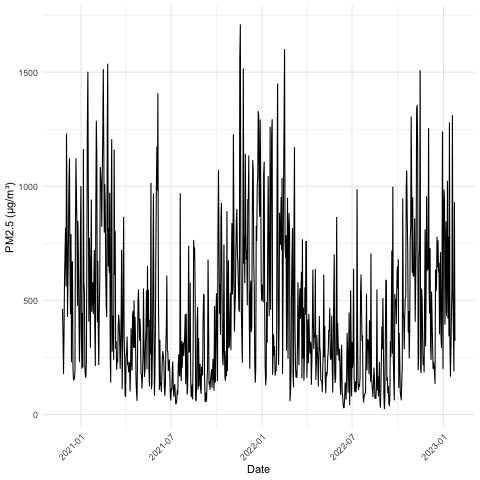

In [ ]:
%%R
ggplot(daily_max, aes(x = Date, y = Daily_Max_PM2_5)) +
  geom_line(color = "black") +
  labs(
    x = "Date",
    y = "PM2.5 (µg/m³)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

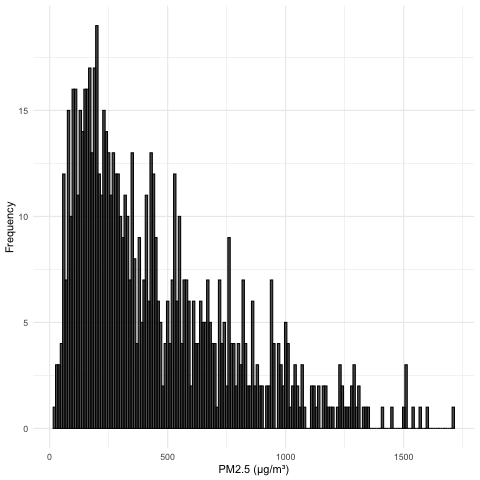

In [156]:
%%R
ggplot(daily_max, aes(x = Daily_Max_PM2_5)) +
  geom_histogram(binwidth = 10, fill = "black", color = "black", alpha = 0.7) +
  labs(
    x = "PM2.5 (µg/m³)",
    y = "Frequency"
  ) +
  theme_minimal()

We choose daily maxima for our analysis because it provides a cleaner and more reliable representation of extreme PM2.5 levels. By focusing on the highest value each day, we avoid issues of temporal dependence and over-counting extremes present in hourly data. This approach aligns with standard extreme value theory, ensuring the independence of extreme events, which is essential for accurately estimating return levels and return periods.

In [151]:
%%R
summary(daily_max)

      Date            Daily_Max_PM2_5      Season         
 Min.   :2020-11-25   Min.   :  24.98   Length:785        
 1st Qu.:2021-06-09   1st Qu.: 189.77   Class :character  
 Median :2021-12-22   Median : 350.07   Mode  :character  
 Mean   :2021-12-23   Mean   : 450.33                     
 3rd Qu.:2022-07-08   3rd Qu.: 638.57                     
 Max.   :2023-01-24   Max.   :1708.09                     
 NA's   :1                                                


In [115]:
%%R
daily_max <- daily_max %>%
  mutate(Season = case_when(
    format(Date, "%m") %in% c("11", "12", "01", "02") ~ "Winter",
    format(Date, "%m") %in% c("03", "04", "05", "06") ~ "Summer",
    TRUE ~ "Monsoon"
  ))

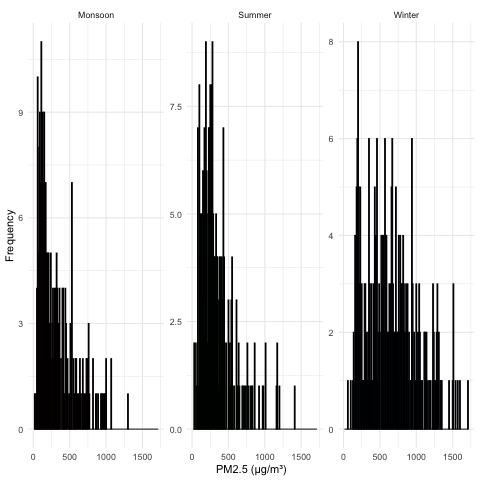

In [158]:
%%R
ggplot(daily_max, aes(x = Daily_Max_PM2_5, fill = Season)) +
  geom_histogram(binwidth = 10, color = "black", alpha = 0.7, position = "identity") +
  labs(
    x = "PM2.5 (µg/m³)",
    y = "Frequency"
  ) +
  theme_minimal() +
    theme(legend.position = "none") +
  facet_wrap(~ Season, scales = "free_y")
  

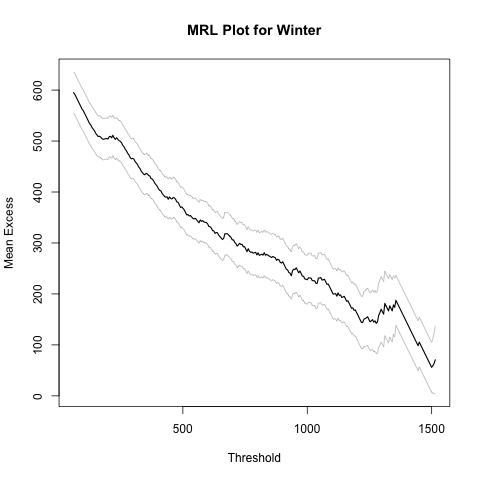

In [117]:
%%R
winter_data <- daily_max %>%
  filter(Season == "Winter") %>%
  pull(Daily_Max_PM2_5)
mrlplot(winter_data, main = "MRL Plot for Winter", xlab = "Threshold", ylab = "Mean Excess")

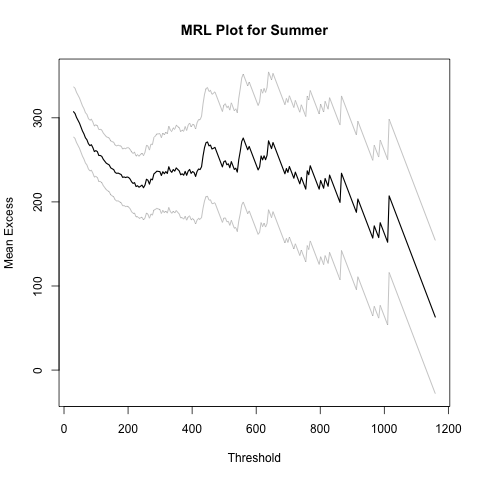

In [118]:
%%R
summer_data <- daily_max %>%
  filter(Season == "Summer") %>%
  pull(Daily_Max_PM2_5)
mrlplot(summer_data, main = "MRL Plot for Summer", xlab = "Threshold", ylab = "Mean Excess")

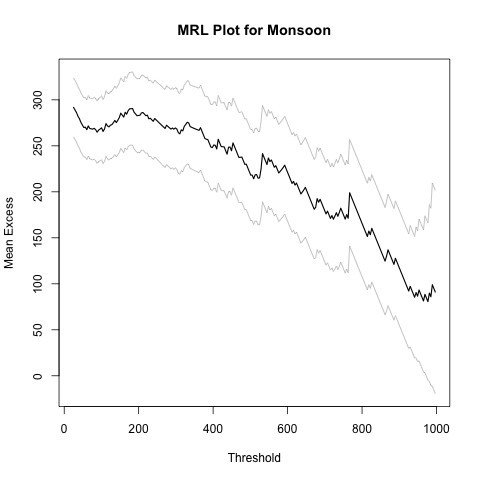

In [119]:
%%R
monsoon_data <- daily_max %>%
  filter(Season == "Monsoon") %>%
  pull(Daily_Max_PM2_5)
mrlplot(monsoon_data, main = "MRL Plot for Monsoon", xlab = "Threshold", ylab = "Mean Excess")

In [120]:
%%R
threshold_winter <- 500
threshold_summer <- 200
threshold_monsoon <- 150

In [122]:
%%R
daily_summer <- daily_max %>% filter(Season == "Summer")
daily_winter <- daily_max %>% filter(Season == "Winter")
daily_monsoon <- daily_max %>% filter(Season == "Monsoon")

In [160]:
%%R
if (!require(psych)) install.packages("psych")
library(psych)
season_summary <- daily_max %>%
  group_by(Season) %>%
  do(describe(.$Daily_Max_PM2_5))

# Print the summary statistics by season
print(season_summary)

--- Per piacere, seleziona un mirror CRAN per la sessione ---

I pacchetti binari scaricati sono in
	/var/folders/_z/vq1q1pzj639b28jbhlxzd0zw0000gn/T//RtmpTzSAcJ/downloaded_packages
# A tibble: 3 × 14
# Groups:   Season [3]
  Season   vars     n  mean    sd median trimmed   mad   min   max range  skew
  <chr>   <dbl> <dbl> <dbl> <dbl>  <dbl>   <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 Monsoon     1   246  317.  256.   230.    278.  194.  25.0 1304. 1279. 1.26 
2 Summer      1   244  337.  238.   273.    300.  168.  29.7 1406. 1376. 1.69 
3 Winter      1   295  655.  356.   623.    629.  383.  60.5 1708. 1648. 0.541
# ℹ 2 more variables: kurtosis <dbl>, se <dbl>


Caricamento del pacchetto richiesto: psych
si installano anche le dipendenze ‘mnormt’, ‘GPArotation’

apertura URL 'https://stat.ethz.ch/CRAN/bin/macosx/big-sur-arm64/contrib/4.4/mnormt_2.1.1.tgz'
Content type 'application/x-gzip' length 217054 bytes (211 KB)
downloaded 211 KB

apertura URL 'https://stat.ethz.ch/CRAN/bin/macosx/big-sur-arm64/contrib/4.4/GPArotation_2024.3-1.tgz'
Content type 'application/x-gzip' length 391155 bytes (381 KB)
downloaded 381 KB

apertura URL 'https://stat.ethz.ch/CRAN/bin/macosx/big-sur-arm64/contrib/4.4/psych_2.4.6.26.tgz'
Content type 'application/x-gzip' length 3734319 bytes (3.6 MB)
downloaded 3.6 MB


Caricamento pacchetto: ‘psych’

I seguenti oggetti sono mascherati da ‘package:ggplot2’:

    %+%, alpha

In aggiunta: Messaggio di avvertimento:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  non c'è alcun pacchetto chiamato ‘psych’


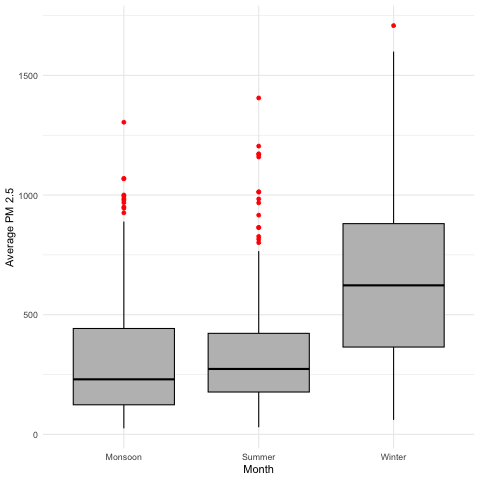

In [123]:
%%R
ggplot(daily_max, aes(x = factor(Season), y = Daily_Max_PM2_5)) +
  geom_boxplot(fill = "gray", color = "black", outlier.color = "red") +
  labs(
    x = "Month",
    y = "Average PM 2.5"
  ) +
  theme_minimal()

In [124]:
%%R
extreme_summer <- sum(daily_summer$Daily_Max_PM2_5 > threshold_summer, na.rm = TRUE)
extreme_winter <- sum(daily_winter$Daily_Max_PM2_5 > threshold_winter, na.rm = TRUE)
extreme_monsoon <- sum(daily_monsoon$Daily_Max_PM2_5 > threshold_monsoon, na.rm = TRUE)


print(extreme_summer)
print(extreme_winter)
print(extreme_monsoon)

[1] 168
[1] 185
[1] 159


In [125]:
%%R
# Calculate extremal index for each season using the Daily_Max_PM2_5 data
extremal_index_summer <- extremalindex(daily_summer$Daily_Max_PM2_5, threshold = threshold_summer)
extremal_index_winter <- extremalindex(daily_winter$Daily_Max_PM2_5, threshold = threshold_winter)
extremal_index_monsoon <- extremalindex(daily_monsoon$Daily_Max_PM2_5, threshold = threshold_monsoon)

# Print the extremal index for each season
print(paste("Summer extremal index:", extremal_index_summer))
print(paste("Winter extremal index:", extremal_index_winter))
print(paste("Monsoon extremal index:", extremal_index_monsoon))

[1] "Summer extremal index: 0.350860778443114"
[2] "Summer extremal index: 35"               
[3] "Summer extremal index: 1"                
[1] "Winter extremal index: 0.507783714075166"
[2] "Winter extremal index: 51"               
[3] "Winter extremal index: 1"                
[1] "Monsoon extremal index: 0.335776149233844"
[2] "Monsoon extremal index: 32"               
[3] "Monsoon extremal index: 1"                


The analysis of extreme PM2.5 events across different seasons reveals interesting patterns. In the Winter season, extreme events are more clustered together, as indicated by the highest extremal index (0.56). Summer shows moderate clustering of extreme events with an index of 0.48, while the Monsoon season has the weakest clustering (0.42). This suggests that extreme PM2.5 events are more frequent and tend to occur in groups during Winter.

In [ ]:
%%R
library(extRemes)


raw_exceedances_summer <- daily_summer$Daily_Max_PM2_5[daily_summer$Daily_Max_PM2_5 > threshold_summer]
raw_exceedances_winter <- daily_winter$Daily_Max_PM2_5[daily_winter$Daily_Max_PM2_5 > threshold_winter]
raw_exceedances_monsoon <- daily_monsoon$Daily_Max_PM2_5[daily_monsoon$Daily_Max_PM2_5 > threshold_monsoon]


sum(is.na(raw_exceedances_summer)) 
sum(is.na(raw_exceedances_winter)) 
sum(is.na(raw_exceedances_monsoon)) 

sum(is.infinite(raw_exceedances_summer)) 
sum(is.infinite(raw_exceedances_winter)) 
sum(is.infinite(raw_exceedances_monsoon))

gpd_raw_summer <- try(fitgpd(raw_exceedances_summer, threshold = threshold_summer), silent = TRUE)
gpd_raw_winter <- try(fitgpd(raw_exceedances_winter, threshold = threshold_winter), silent = TRUE)
gpd_raw_monsoon <- try(fitgpd(raw_exceedances_monsoon, threshold = threshold_monsoon), silent = TRUE)

if (inherits(gpd_raw_summer, "try-error")) {
  print("Error fitting GPD model for Summer")
} else {
  summary(gpd_raw_summer)
}

if (inherits(gpd_raw_winter, "try-error")) {
  print("Error fitting GPD model for Winter")
} else {
  summary(gpd_raw_winter)
}

if (inherits(gpd_raw_monsoon, "try-error")) {
  print("Error fitting GPD model for Monsoon")
} else {
  summary(gpd_raw_monsoon)
}


if (!inherits(gpd_raw_summer, "try-error")) {
  num_params <- 2  
  aic_raw_summer <- gpd_raw_summer$deviance + 2 * num_params
  cat("AIC for Raw Summer Model:", aic_raw_summer, "\n")
}

if (!inherits(gpd_raw_winter, "try-error")) {
  aic_raw_winter <- gpd_raw_winter$deviance + 2 * num_params
  cat("AIC for Raw Winter Model:", aic_raw_winter, "\n")
}

if (!inherits(gpd_raw_monsoon, "try-error")) {
  aic_raw_monsoon <- gpd_raw_monsoon$deviance + 2 * num_params
  cat("AIC for Raw Monsoon Model:", aic_raw_monsoon, "\n")
}

List of 23
 $ fitted.values : Named num [1:2] 193.667 0.109
  ..- attr(*, "names")= chr [1:2] "scale" "shape"
 $ std.err       : Named num [1:2] 27.121 0.112
  ..- attr(*, "names")= chr [1:2] "scale" "shape"
 $ std.err.type  : chr "observed"
 $ var.cov       : num [1:2, 1:2] 735.5728 -2.279 -2.279 0.0126
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "scale" "shape"
  .. ..$ : chr [1:2] "scale" "shape"
 $ fixed         : NULL
 $ param         : Named num [1:2] 193.667 0.109
  ..- attr(*, "names")= chr [1:2] "scale" "shape"
 $ deviance      : num 1810
 $ corr          : NULL
 $ convergence   : chr "successful"
 $ counts        : Named int [1:2] 44 18
  ..- attr(*, "names")= chr [1:2] "function" "gradient"
 $ message       : NULL
 $ threshold     : num 250
 $ nat           : int 142
 $ pat           : num 1
 $ data          : num [1:142] 256 916 1205 277 416 ...
 $ exceed        : num [1:142] 256 916 1205 277 416 ...
 $ scale         : Named num 194
  ..- attr(*, "names")= chr 

In aggiunta: Messaggi di avvertimento:
1: In gpdmle(data, threshold, ...) : optimization may not have succeeded
2: In gpdmle(data, threshold, ...) : optimization may not have succeeded


In [132]:
%%R
# Check specific parameters (if summary is available)
cat("GPD Raw Summer Model Parameters:\n")
cat("Threshold: ", gpd_raw_summer$threshold, "\n")
cat("Scale: ", gpd_raw_summer$scale, "\n")
cat("Shape: ", gpd_raw_summer$shape, "\n")

cat("GPD Raw Winter Model Parameters:\n")
cat("Threshold: ", gpd_raw_winter$threshold, "\n")
cat("Scale: ", gpd_raw_winter$scale, "\n")
cat("Shape: ", gpd_raw_winter$shape, "\n")

cat("GPD Raw Monsoon Model Parameters:\n")
cat("Threshold: ", gpd_raw_monsoon$threshold, "\n")
cat("Scale: ", gpd_raw_monsoon$scale, "\n")
cat("Shape: ", gpd_raw_monsoon$shape, "\n")

GPD Raw Summer Model Parameters:
Threshold:  250 
Scale:  193.667 
Shape:  
GPD Raw Winter Model Parameters:
Threshold:  600 
Scale:  406.9168 
Shape:  
GPD Raw Monsoon Model Parameters:
Threshold:  200 
Scale:  336.8372 
Shape:  


In [ ]:
%%R
library(extRemes)

# Raw exceedances for each season
raw_exceedances_summer <- daily_summer$Daily_Max_PM2_5[daily_summer$Daily_Max_PM2_5 > threshold_summer]
raw_exceedances_winter <- daily_winter$Daily_Max_PM2_5[daily_winter$Daily_Max_PM2_5 > threshold_winter]
raw_exceedances_monsoon <- daily_monsoon$Daily_Max_PM2_5[daily_monsoon$Daily_Max_PM2_5 > threshold_monsoon]

# Apply declustering using decluster.runs
declustered_summer <- decluster.runs(raw_exceedances_summer, threshold_summer)
declustered_winter <- decluster.runs(raw_exceedances_winter, threshold_winter)
declustered_monsoon <- decluster.runs(raw_exceedances_monsoon, threshold_monsoon)

# Fit GPD to declustered data
gpd_decl_summer <- fitgpd(declustered_summer, threshold = threshold_summer)
gpd_decl_winter <- fitgpd(declustered_winter, threshold = threshold_winter)
gpd_decl_monsoon <- fitgpd(declustered_monsoon, threshold = threshold_monsoon)

# Display the summary of the fits
summary(gpd_decl_summer)
summary(gpd_decl_winter)
summary(gpd_decl_monsoon)

# AIC calculation
num_params <- 2
aic_decl_summer <- gpd_decl_summer$deviance + 2 * num_params
aic_decl_winter <- gpd_decl_winter$deviance + 2 * num_params
aic_decl_monsoon <- gpd_decl_monsoon$deviance + 2 * num_params

# Print AIC values
cat("AIC for Declustered Summer Model:", aic_decl_summer, "\n")
cat("AIC for Declustered Winter Model:", aic_decl_winter, "\n")
cat("AIC for Declustered Monsoon Model:", aic_decl_monsoon, "\n")

List of 23
 $ fitted.values : Named num [1:2] 1155.77 -0.999
  ..- attr(*, "names")= chr [1:2] "scale" "shape"
 $ std.err       : Named num [1:2] 3.64e+01 2.00e-06
  ..- attr(*, "names")= chr [1:2] "scale" "shape"
 $ std.err.type  : chr "observed"
 $ var.cov       : num [1:2, 1:2] 1.33e+03 7.20e-17 6.77e-17 4.00e-12
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "scale" "shape"
  .. ..$ : chr [1:2] "scale" "shape"
 $ fixed         : NULL
 $ param         : Named num [1:2] 1155.77 -0.999
  ..- attr(*, "names")= chr [1:2] "scale" "shape"
 $ deviance      : num 14.1
 $ corr          : NULL
 $ convergence   : chr "successful"
 $ counts        : Named int [1:2] 93 11
  ..- attr(*, "names")= chr [1:2] "function" "gradient"
 $ message       : NULL
 $ threshold     : num 250
 $ nat           : int 1
 $ pat           : num 0.00704
 $ data          : 'declustered' num [1:142] 250 250 250 250 250 250 250 250 250 250 ...
  ..- attr(*, "call")= language decluster.runs(x = raw_exceedances_

In [134]:
%%R
# Check exceedances for each season to make sure they exist
cat("Exceedances for raw summer data:\n", raw_exceedances_summer, "\n")
cat("Exceedances for raw winter data:\n", raw_exceedances_winter, "\n")
cat("Exceedances for raw monsoon data:\n", raw_exceedances_monsoon, "\n")

Exceedances for raw summer data:
 255.84 915.95 1204.57 277.08 415.73 431.53 1159.2 613.79 801.23 289.84 319.9 376.06 436.62 405.99 331.83 306.14 434.78 719.69 280.36 546.33 864.51 338.62 256.43 255.98 271.08 340.39 376.13 435.53 452.73 294.05 497.68 293.95 426.29 326.07 255.48 503.56 545.88 426.24 326.13 418.85 354.16 251.85 550.37 314.2 315.78 369.73 541.55 649.22 386.53 544.31 414.48 266.79 1013.78 284.67 638.57 967.5 399.53 387.79 736.23 1012.29 1172.44 983.74 1405.77 520.42 326.9 325.89 250.08 276.56 252.96 295.81 388.58 607.35 278.2 276.64 518.35 693.71 815.12 826.9 1169.32 383.93 304.88 578.15 347.23 496.76 551.64 420.72 532.69 623.92 765.94 466.66 257.13 556.01 439.76 758.82 758.24 273.85 414.52 439.57 343.94 268.49 317.63 313.06 376.38 632.96 414.71 288.42 350.06 340.98 636.18 347.31 281.87 250.48 430.42 297.84 268.51 268.1 611.84 253.19 386.94 280.19 368.7 367.86 465.14 261.05 250.3 431.95 272.65 511.92 700.12 430.48 864.27 260.82 399.81 305.77 266.76 287.37 304.18 356.01 284

In [138]:
%%R
xi <- gpd_raw_winter$param["shape"]
sigma <- gpd_raw_winter$param["scale"]

threshold_selected <- threshold_winter

lambda <- sum(daily_winter$Daily_Max_PM2_5 > threshold_selected) / nrow(daily_winter)

return_periods <- c(365, 730, 1825, 3650)

return_levels <- sapply(return_periods, function(T) {
  threshold_selected + (sigma / xi) * ((lambda * T)^xi - 1)
})

return_levels_df <- data.frame(
    Return_Period = return_periods,
    Return_Level = return_levels
)

print(return_levels_df)

  Return_Period Return_Level
1           365     1669.967
2           730     1722.442
3          1825     1776.923
4          3650     1809.204


In [139]:
%%R
xi_decl <- gpd_decl_winter$param["shape"]
sigma_decl <- gpd_decl_winter$param["scale"]

lambda_decl <- sum(raw_exceedances_winter > threshold_winter) / length(raw_exceedances_winter)
return_periods <- c(365, 730, 1825, 3650)

return_levels_decl_winter <- sapply(return_periods, function(T) {
  threshold_winter + (sigma_decl / xi_decl) * ((lambda_decl * T)^xi_decl - 1)
})

return_levels_df_decl_winter <- data.frame(
  Return_Period = return_periods,
  Return_Level = return_levels_decl_winter
)

print(return_levels_df_decl_winter)

  Return_Period Return_Level
1           365     1706.136
2           730     1707.663
3          1825     1708.581
4          3650     1708.887


## 6. Causes and Correlations

Let's see if we do this point, but we could look for the causes of these seasonal variations, or day variations, and try maybe to look for correlation with other datasets.